## Final Project Submission

Please fill out:
* Student name: **Darius Fuller**
* Student pace: self paced / **part time** / full time
* Scheduled project review date/time: **TBD**
* Instructor name: **James Irving**
* Blog post URL: **Insert Here**


### The problem and plans

#### The problem and inspiration

The **problem** I am going to be investigating is whether or not we can use machine learning and statistical modeling skills to predict UFC fights. 

The **goal** is to create a model that can *accurately* produce a probability value for either fighter to win a given fight. 

This type of information will be valuable to fans, fighters, and those looking to do business in the UFC or other combat sports. Specifically, statistics are becoming more important for sports viewers. It would make most feel better about their viewing if they knew they saw something near impossible, and had the numbers to back that feeling up. 

#### The plan

The dataset I used in this project is found [here](https://www.kaggle.com/rajeevw/ufcdata). 

There are 145 features in this dataset and over 5000 rows. According to the site, it details every UFC fight up until June of 2019. Although I won't explain the full details of every single highlight, I will explain in general.

There is information about:
* Fighter's Win/Loss/Draw record prior to fight
* Fighter's method of winning fights
* Fighting Stance
* Pre-calculated averages covering:
    * Significant strikes
    * Submissions
    * 'Passing' on the ground
    * etc.
* Physical Attributes

I plan to use this information after some preparation to make a multi-class or binary (if necessary) classifier such as a decision tree and ensemble methods to achieve an accuracy score of **80% minimum**.

## Goods

### Functions and Classes

In [2]:
## Importing ALL the necessary packages
import warnings
import pandas as pd
import missingno as mg
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import tzlocal
import datetime as dt
import xgboost as xgb
import sklearn.metrics as metrics
from yellowbrick.classifier import ROCAUC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE

warnings.filterwarnings('ignore')
%matplotlib inline

C:\Users\d_ful\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\d_ful\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\d_ful\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module i

In [132]:
class Timer():
    
    """Timer class designed to keep track of and save modeling runtimes. It
    will automatically find your local timezone. Methods are .stop, .start,
    .record, and .now"""
    
    def __init__(self, fmt="%m/%d/%Y - %I:%M %p", verbose=None):
        import tzlocal
        self.verbose = verbose
        self.tz = tzlocal.get_localzone()
        self.fmt = fmt
        
    def now(self):
        import datetime as dt
        return dt.datetime.now(self.tz)
    
    def start(self):
        if self.verbose:
            print(f'---- Timer started at: {self.now().strftime(self.fmt)} ----')
        self.started = self.now()
        
    def stop(self):
        print(f'---- Timer stopped at: {self.now().strftime(self.fmt)} ----')
        self.stopped = self.now()
        self.time_elasped = (self.stopped - self.started)
        print(f'---- Time elasped: {self.time_elasped} ----')
        
    def record(self):
        try:
            self.lap = self.time_elasped
            return self.lap
        except:
            return print('---- Timer has not been stopped yet... ----')
        
    def __repr__(self):
        return f'---- Timer object: TZ = {self.tz} ----'

In [133]:
def fit_n_pred(clf_, X_tr, X_te, y_tr):
    
    """Takes in Classifier, training data (X,y), and test data(X). Will output 
    predictions based upon both the training and test data using the sklearn
    .predict method. MUST unpack into two variables (train, test)."""
    
    clf_.fit(X_tr, y_tr)

    y_hat_trn = clf_.predict(X_tr)
    y_hat_tes = clf_.predict(X_te)
    
    display(clf_)
    return y_hat_trn, y_hat_tes

In [134]:
def plot_importance(tree, X_tr, top_n=10, figsize=(10,10), ax=None):
    
    """Takes in pre-fit descision tree and the training X data used. Will output
    a horizontal bar plot (.plt) of the top 10 (default) features used in said tree."""
    
    import pandas as pd
    import matplotlib as plt
    
    imps = pd.Series(tree.feature_importances_,index=X_tr.columns)
    imps.sort_values(ascending=True).tail(top_n).plot(kind='barh',figsize=figsize, ax=ax)
    return imps

In [135]:
def evaluate_model(clf_, X_tr, X_te, y_tr, y_te, cls_rpt_tr=False, show=True, cls_labels=None, binary=False):
    
    
    """Takes any classifier, train/test data for X/y, labels for graph (optional).
    Will output (if show) a Sklearn Classification Report and Confusion Matrix
    along with a Yellowbrick ROC/AUC curve and Feature Importance graph (if a tree).
    Otherwise will return training/test predictions."""
    
    import sklearn.metrics as metrics
    import matplotlib as plt
    from yellowbrick.classifier import ROCAUC
    
    ## Fit and predict 
    y_hat_trn, y_hat_tes = fit_n_pred(clf_, X_tr, X_te, y_tr)
    
    if show:
        ## Classification Report / Scores
        if cls_rpt_tr:
            print('Classification Report Train')
            print(metrics.classification_report(y_tr,y_hat_trn))
        else:
            print('Classification Report Test')
            print(metrics.classification_report(y_te,y_hat_tes))

        ## Confusion Matrix
        fig, ax = plt.subplots(figsize=(10,5), ncols=2)
        
        metrics.plot_confusion_matrix(clf_,X_te,y_te,cmap="Greens",
                                      normalize='all',ax=ax[0])
        ax[0].set(title='Confusion Matrix Test Data')
        ax[0].grid(False)        

        roc = ROCAUC(clf_, classes=cls_labels, ax=ax[1])
        roc.fit(X_tr, y_tr)
        roc.score(X_te, y_te)
        roc.finalize()
            
        plt.tight_layout()
        plt.show()
        
        if binary:
            try:
                imps = plot_importance(clf_, X_tr)
            except:
                imps = None
        
    else:
        return y_hat_trn, y_hat_tes

In [136]:
def time_models(x_tr, x_te, y_tr, y_te, mod_list, mod_labels, time_obj, 
                count=0, keep=True, show=True, cls_lab=None):
    
    """Takes in X/y data (train and test), list of model(s) and Timer() object.
    Optional parameters determine (with keep=True) which label to start with 
    (count) and (with show=True) what class labels to display (cls_lab). Outputs
    visuals from evaluate_model() and duration dictionary if opted-in."""
    
    durations = {}
    
    for m in mod_list:
        if show:
            time_obj.start()
            evaluate_model(m, x_tr, x_te, y_tr, y_te, cls_labels=cls_lab)
            time_obj.stop()
        else:
            time_obj.start()
            a, b = evaluate_model(m, x_tr, x_te, y_tr, y_te, show=False)
            time_obj.stop()
        
        if keep:
            durations[mod_labels[count]] = time_obj.record().total_seconds()
        
        count += 1
    
    if keep:
        return durations
    
    else:
        return f'---- All done! Completed {count} models. ----'

In [139]:
def summarize_model(clf_, X_tr, X_te, y_tr, y_te, tree=False):
    
    """Takes any classifier and train/test data for X/y. Will output Sklearn
    Classification Report and Confusion Matrix. If classifier is decision tree
    like, can select for a feature importance graph."""
    
    import sklearn.metrics as metrics
    import matplotlib.pyplot as plt
    
    y_hat_tr, y_hat_te = fit_n_pred(clf_, X_tr, X_te, y_tr)
    print('Classification Report:')
    print(metrics.classification_report(y_te, y_hat_te))
    
    if tree:
        fig, ax = plt.subplots(figsize=(10,5), nrows=2)

        metrics.plot_confusion_matrix(clf_,X_te,y_te,cmap="Greens", normalize='all',
                                     ax=ax[0])
        ax[0].set(title='Confusion Matrix')
        ax[0].grid(False)

        plot_importance(clf_, X_tr, ax=ax[1])
        plt.tight_layout()
        
    else:
        metrics.plot_confusion_matrix(clf_,X_te,y_te,cmap="Greens", normalize='all')
        plt.title('Confusion Matrix')
        plt.grid(False)
        plt.tight_layout()

In [137]:
def grid_searcher(clf_, params, X_tr, X_te, y_tr, y_te, cv=None, keep_t=False,
                  train_score=True):
    
    """Takes any classifier, train/test data for X/y, and dict of parameters to
    iterate over. Optional parameters select for cross-validation tuning, keeping
    time for running the gridsearch, and returning training scores when done.
    Default parameters only return the fitted grid search object. MUST HAVE Timer
    class imported."""
    
    from sklearn.model_selection import GridSearchCV
    import numpy as np
    
    ## Instantiate obj. with our targets
    grid_s = GridSearchCV(clf_, params, cv=cv, return_train_score=train_score)
    
    ## Time and fit run the 'search'
    time = Timer()
    time.start()
    grid_s.fit(X_tr, y_tr)
    time.stop()
    
    ## Display results
    tr_score = np.mean(grid_s.cv_results_['mean_train_score'])
    te_score = grid_s.score(X_te, y_te)
    print(f'Mean Training Score: {tr_score :.2%}')
    print(f'Mean Test Score: {te_score :.2%}')
    print('Best Parameters:')
    print(grid_s.best_params_)
    
    ## Time keeping and grid obj
    if keep_t:
        lap = time.record().total_seconds()
        print('**********All done!**********')
        return grid_s, lap
    else:
        return grid_s

In [106]:
def NA_handler_bin(df):
    
    """VERY specific helper function designed to minimize code length in notebook.
    Details the preprocessing steps used to Fill NAs according to specific
    strategies."""
    
    ## Check dist
    print('Stance Distributions:')
    print(df['B_Stance'].value_counts(normalize=True), '\n')
    print(df['R_Stance'].value_counts(normalize=True))
    
    ## Making list for random choices
    stance_list = list(df['B_Stance'].dropna().unique())
    print('\nStances:')
    print(stance_list, '\n')

    ## Making array of probabilities for corresp. stances
    print('Stance Probabilities:')
    stance_ps = df['B_Stance'].value_counts(normalize=True).values
    print(stance_ps, '\n')
    
    ## Using for loop to randomly fill stances according to probabilities 
    helper = ['B_Stance', 'R_Stance']
    for col in helper:
        df[col] = df[col].fillna(np.random.choice(stance_list, p=stance_ps))
        
    ## Using .groupby to find aggregrate stats for groups
    height_grouped = df.groupby('R_Height_cms').agg('mean')
    
    ## Making dictionary of reach values acc. to height grouping
    reach_by_height = dict(height_grouped['R_Reach_cms'])
    
    ## Same as above but targeting Height values to be filled
    reach_grouped = df.groupby('R_Reach_cms').agg('mean')
    height_by_reach = dict(reach_grouped['R_Height_cms'])
    
    ## Targeting weight values to be filled
    weight_cls_grouped = df.groupby('weight_class').agg('mean')
    weight_by_class = dict(weight_cls_grouped['R_Weight_lbs'])
    
    ## Mapping groupby aggregates to NAs in corresp. columns
    cols1 = ['B_Reach_cms', 'R_Reach_cms']
    for col in cols1:
        df[col] = df[col].fillna(df['R_Height_cms'].map(reach_by_height))
    cols2 = ['B_Height_cms', 'R_Height_cms']
    for col in cols2:
        df[col] = df[col].fillna(df['R_Reach_cms'].map(height_by_reach))
    cols3 = ['B_Weight_lbs', 'R_Weight_lbs']
    for col in cols3:
        df[col] = df[col].fillna(df['weight_class'].map(weight_by_class))
    
    ## Checking for rows with NAs after mapping
    print('Null Values Remaining:')
    display(df.loc[(pd.isnull(df.R_Reach_cms)), 'R_Reach_cms'])
    display(df.loc[(pd.isnull(df.B_Reach_cms)), 'B_Reach_cms'])
    
    ## Using mapped values according to weight class
    ## Indices taken from above
    val_R_rch2_bin = {4800: 196.393271, 4814: 196.393271}
    val_B_rch2_bin = {4800: 196.227178, 4814: 196.227178}
    cols = ['R_Reach_cms', 'B_Reach_cms']
    
    ## Assigning values acc. to column
    df[cols[0]] = df[cols[0]].fillna(val_R_rch2_bin)

    df[cols[1]] = df[cols[1]].fillna(val_B_rch2_bin)
    
    ## Creating variable to hold age mean for filling by taking midpoint 
    ## between the columns
    print('Age Mean:')
    print(df[['B_age', 'R_age']].mean(), '\n')
    print('Midpoint Age Mean:')
    age_mean = (df['B_age'].mean() + df['R_age'].mean()) / 2
    print(age_mean)

    ## Fill NA values by the mean age overall
    df['B_age'] = df['B_age'].fillna(age_mean)
    df['R_age'] = df['R_age'].fillna(age_mean)
    
    ## Missingno visual check
    display(mg.matrix(df));
    
    return df

In [3]:
## In order to cut down on code length, all created classes and functions have 
## been moved to the 'functions.py' file.

import functions as dlf

### Initial Check

In [4]:
pd.set_option('max_columns', 0)

In [5]:
## Loading data with Pandas + quick look
ufc_df = pd.read_csv('ufc_data.csv')
print(ufc_df.shape)
ufc_df.head()

(5144, 145)


,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,weight_class,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_BODY_att,B_avg_BODY_landed,B_avg_CLINCH_att,B_avg_CLINCH_landed,B_avg_DISTANCE_att,B_avg_DISTANCE_landed,B_avg_GROUND_att,B_avg_GROUND_landed,B_avg_HEAD_att,B_avg_HEAD_landed,B_avg_KD,B_avg_LEG_att,B_avg_LEG_landed,B_avg_PASS,B_avg_REV,B_avg_SIG_STR_att,B_avg_SIG_STR_landed,B_avg_SIG_STR_pct,B_avg_SUB_ATT,B_avg_TD_att,B_avg_TD_landed,B_avg_TD_pct,B_avg_TOTAL_STR_att,B_avg_TOTAL_STR_landed,B_longest_win_streak,B_losses,B_avg_opp_BODY_att,B_avg_opp_BODY_landed,...,R_avg_opp_BODY_att,R_avg_opp_BODY_landed,R_avg_opp_CLINCH_att,R_avg_opp_CLINCH_landed,R_avg_opp_DISTANCE_att,R_avg_opp_DISTANCE_landed,R_avg_opp_GROUND_att,R_avg_opp_GROUND_landed,R_avg_opp_HEAD_att,R_avg_opp_HEAD_landed,R_avg_opp_KD,R_avg_opp_LEG_att,R_avg_opp_LEG_landed,R_avg_opp_PASS,R_avg_opp_REV,R_avg_opp_SIG_STR_att,R_avg_opp_SIG_STR_landed,R_avg_opp_SIG_STR_pct,R_avg_opp_SUB_ATT,R_avg_opp_TD_att,R_avg_opp_TD_landed,R_avg_opp_TD_pct,R_avg_opp_TOTAL_STR_att,R_avg_opp_TOTAL_STR_landed,R_total_rounds_fought,R_total_time_fought(seconds),R_total_title_bouts,R_win_by_Decision_Majority,R_win_by_Decision_Split,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_wins,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
0,Henry Cejudo,Marlon Moraes,Marc Goddard,2019-06-08,"Chicago, Illinois, USA",Red,True,Bantamweight,5,0.0,4.0,0.0,9.200000,6.000000,0.200000,0.000000,62.600000,20.600000,2.600000,2.000000,48.600000,11.200000,0.800000,7.6,5.400000,0.400000,0.000000,65.40,22.600000,0.466000,0.400000,0.80000,0.200000,0.100000,66.400000,23.600000,4.0,1.0,6.400000,4.000000,...,13.300000,8.800000,7.500000,5.100000,90.500000,26.800000,0.800000,0.300000,76.100000,17.300000,0.100000,9.400000,6.100000,0.000000,0.000000,98.800000,32.200000,0.336000,0.000000,0.900000,0.100000,0.050000,110.500000,43.300000,27.0,742.60,3.0,0.0,2.0,4.0,2.0,0.0,0.0,8.0,Orthodox,162.56,162.56,135.0,31.0,32.0
1,Valentina Shevchenko,Jessica Eye,Robert Madrigal,2019-06-08,"Chicago, Illinois, USA",Red,True,Women's Flyweight,5,0.0,3.0,0.0,14.600000,9.100000,11.800000,7.300000,124.700000,42.100000,2.400000,1.900000,112.000000,32.000000,0.000000,12.3,10.200000,0.800000,0.000000,138.90,51.300000,0.399000,0.700000,1.00000,0.500000,0.225000,158.700000,69.600000,3.0,6.0,13.000000,9.300000,...,24.571429,14.142857,10.571429,7.857143,98.571429,32.571429,6.428571,4.285714,61.857143,12.428571,0.000000,29.142857,18.142857,1.142857,0.000000,115.571429,44.714286,0.437143,0.285714,3.285714,0.857143,0.147143,158.142857,82.285714,25.0,1062.00,2.0,0.0,1.0,2.0,0.0,2.0,0.0,5.0,Southpaw,165.10,167.64,125.0,32.0,31.0
2,Tony Ferguson,Donald Cerrone,Dan Miragliotta,2019-06-08,"Chicago, Illinois, USA",Red,False,Lightweight,3,0.0,3.0,0.0,15.354839,11.322581,6.741935,4.387097,84.741935,38.580645,5.516129,3.806452,67.645161,23.258065,0.645161,14.0,12.193548,0.935484,0.096774,97.00,46.774194,0.496129,0.354839,2.16129,0.677419,0.295484,103.709677,52.548387,8.0,8.0,17.903226,11.870968,...,14.466667,8.133333,2.800000,0.733333,91.066667,32.200000,4.866667,2.800000,78.266667,23.200000,0.266667,6.000000,4.400000,0.333333,0.133333,98.733333,35.733333,0.340000,0.066667,2.866667,0.666667,0.131333,102.133333,38.600000,33.0,604.40,2.0,0.0,1.0,3.0,3.0,6.0,1.0,14.0,Orthodox,180.34,193.04,155.0,36.0,35.0
3,Jimmie Rivera,Petr Yan,Kevin MacDonald,2019-06-08,"Chicago, Illinois, USA",Blue,False,Bantamweight,3,0.0,4.0,0.0,17.000000,14.000000,13.750000,11.000000,109.500000,48.750000,13.000000,10.500000,116.250000,53.750000,0.500000,3.0,2.500000,0.500000,0.250000,136.25,70.250000,0.550000,0.250000,2.50000,1.250000,0.287500,154.750000,86.750000,4.0,0.0,12.250000,6.000000,...,20.250000,13.375000,6.875000,5.625000,103.125000,38.500000,0.875000,0.750000,77.375000,20.375000,0.125000,13.250000,11.125000,0.000000,0.000000,110.875000,44.875000,0.446250,0.000000,2.375000,0.000000,0

> Here I am dropping the names of the fighters and referees, which although important, cannot reliably be used in modeling. Referees *do* have an impact on the fight, but *usually* the fighters do the winning and/or losing by their own devices. The same can be said about the location. I am not including the date because you can never use a date again for prediction reliably.

In [5]:
## Set up raw DataFrame w/o unecessary stuff + quick check
cols_to_drop = ['R_fighter', 'B_fighter', 'Referee', 'date', 'location']

df = ufc_df.drop(columns=cols_to_drop).copy()
df.head()

,Winner,title_bout,weight_class,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_BODY_att,B_avg_BODY_landed,B_avg_CLINCH_att,...,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_wins,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
0,Red,True,Bantamweight,5,0.0,4.0,0.0,9.200000,6.000000,0.200000,...,2.0,0.0,0.0,8.0,Orthodox,162.56,162.56,135.0,31.0,32.0
1,Red,True,Women's Flyweight,5,0.0,3.0,0.0,14.600000,9.100000,11.800000,...,0.0,2.0,0.0,5.0,Southpaw,165.10,167.64,125.0,32.0,31.0
2,Red,False,Lightweight,3,0.0,3.0,0.0,15.354839,11.322581,6.741935,...,3.0,6.0,1.0,14.0,Orthodox,180.34,193.04,155.0,36.0,35.0
3,Blue,False,Bantamweight,3,0.0,4.0,0.0,17.000000,14.000000,13.750000,...,1.0,0.0,0.0,6.0,Orthodox,162.56,172.72,135.0,26.0,29.0
4,Blue,False,Heavyweight,3,0.0,1.0,0.0,17.000000,14.500000,2.500000,...,2.0,0.0,0.0,3.0,Southpaw,187.96,190.50,264.0,32.0,26.0


In [6]:
## Checking for null values

#pd.set_option('max_rows', None) ## I had to make sure and check all columns
df.isna().sum()

Winner                             0
title_bout                         0
weight_class                       0
no_of_rounds                       0
B_current_lose_streak              0
B_current_win_streak               0
B_draw                             0
B_avg_BODY_att                  1265
B_avg_BODY_landed               1265
B_avg_CLINCH_att                1265
B_avg_CLINCH_landed             1265
B_avg_DISTANCE_att              1265
B_avg_DISTANCE_landed           1265
B_avg_GROUND_att                1265
B_avg_GROUND_landed             1265
B_avg_HEAD_att                  1265
B_avg_HEAD_landed               1265
B_avg_KD                        1265
B_avg_LEG_att                   1265
B_avg_LEG_landed                1265
B_avg_PASS                      1265
B_avg_REV                       1265
B_avg_SIG_STR_att               1265
B_avg_SIG_STR_landed            1265
B_avg_SIG_STR_pct               1265
B_avg_SUB_ATT                   1265
B_avg_TD_att                    1265
B

> After looking at the website and .csv file directly, the missing values for AVGS appear to be for first fights in the UFC, as there is a '0' streak in the W/L columns for the appropriate row

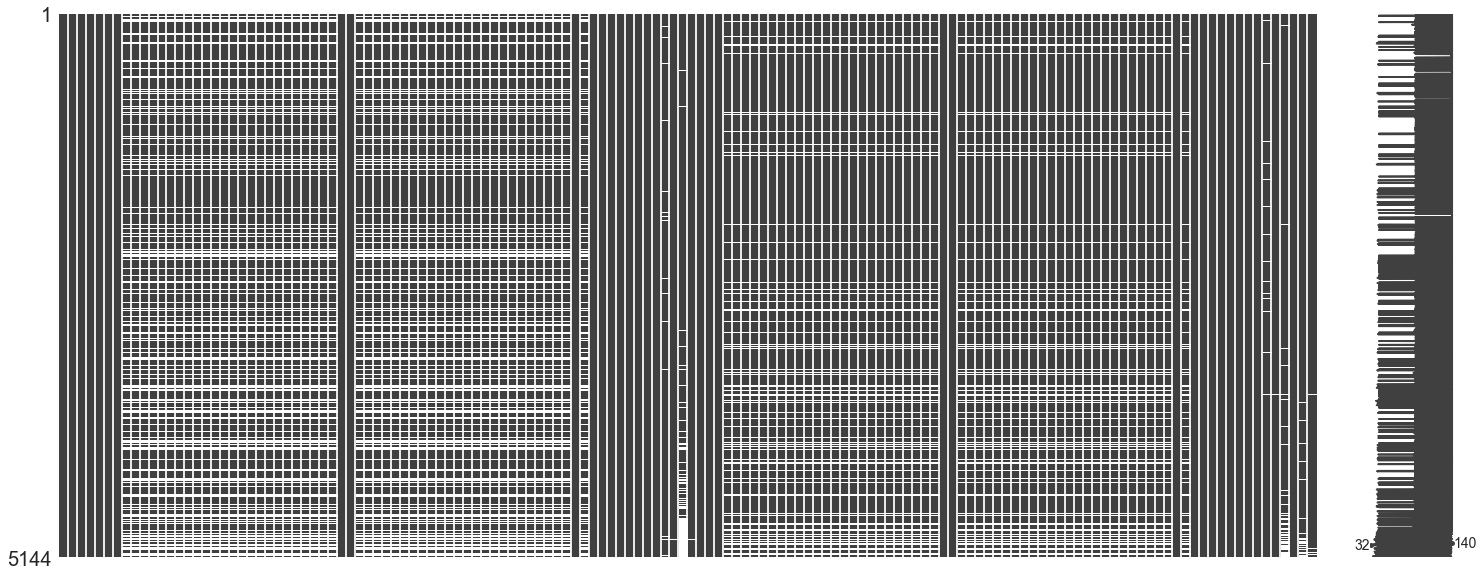

In [7]:
## Visualizing the nulls, looking for patterns

mg.matrix(df);

> This confirms my initial thoughts visually, I will check one last time by filtering those without W/L streaks. (It may be useful later to make a column for first fighters)

> Instead of making a new columns, for those without AVGs, I will fill them with 0's, to represent their 'UFC-only' stats. This could lead to issues later due to these fighters needing to have previous experience in MMA or combat sports in general. In order to net a spot on the fight card, it is likely there *is* data for them, but depending on numerous factors, in order to collect accurate data I would need to spend the time going through each individuals history. 

### Filling N/As 

Replacing Null Values: 
* B/R_avg... & total_time = 0
* B/R_Stance = random choice acc. to probability
* B/R_Reach = groupby Height and use mean
* B/R_Height = groupby Reach and use mean
* B/R_Weight = groupby weight class and use mean
* B/R_age = mean

#### Filling AVGs

In [8]:
## Making list of cols to fill with 0 averages, then doing so
zero_fill_cols = [col for col in df.columns if 'avg' in col]

df_fill = df.copy()

df_fill[zero_fill_cols] = df_fill[zero_fill_cols].fillna(0)

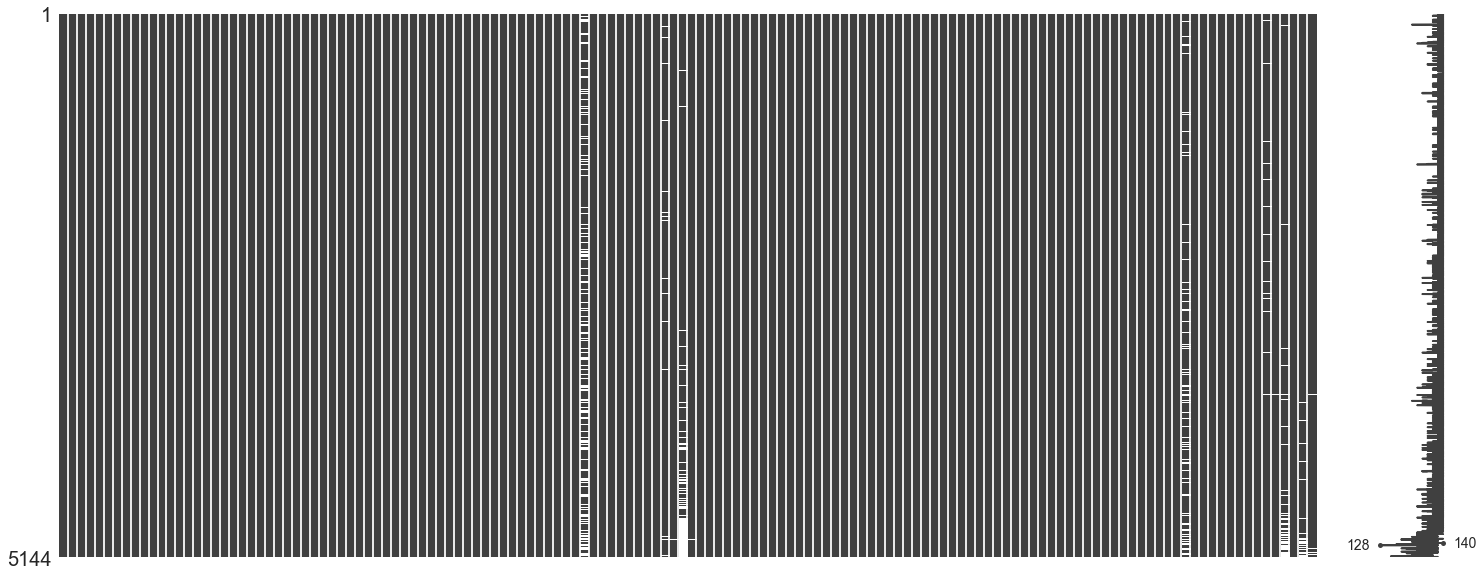

In [9]:
## Sanity check for filled nulls + visual

#pd.set_option('max_rows',None)
#print(df_fill.isna().sum())

mg.matrix(df_fill);

#### Filling Stances

In [10]:
## Checking distributions pt.1

df_fill['B_Stance'].value_counts(normalize=True)

Orthodox       0.768104
Southpaw       0.195587
Switch         0.033701
Open Stance    0.001805
Sideways       0.000802
Name: B_Stance, dtype: float64

In [11]:
## Checking distributions pt.2

df_fill['R_Stance'].value_counts(normalize=True)

Orthodox       0.759880
Southpaw       0.206786
Switch         0.029940
Open Stance    0.002994
Sideways       0.000399
Name: R_Stance, dtype: float64

In [10]:
## set value counts into varible. use .index on varible to get stance list. then use .values for stance ps

In [12]:
## Making list for random choices

stance_list = list(df_fill['B_Stance'].dropna().unique())
print(stance_list)

## Making array of probabilities for corresp. stances
stance_ps = df_fill['R_Stance'].value_counts(normalize=True).values
print(stance_ps)

['Orthodox', 'Switch', 'Southpaw', 'Open Stance', 'Sideways']
[7.59880240e-01 2.06786427e-01 2.99401198e-02 2.99401198e-03
 3.99201597e-04]


In [13]:
## Using for loop to randomly fill stances according to probabilities 
helper = ['B_Stance', 'R_Stance']

for col in helper:
    df_fill[col] = df_fill[col].fillna(np.random.choice(stance_list, p=stance_ps))

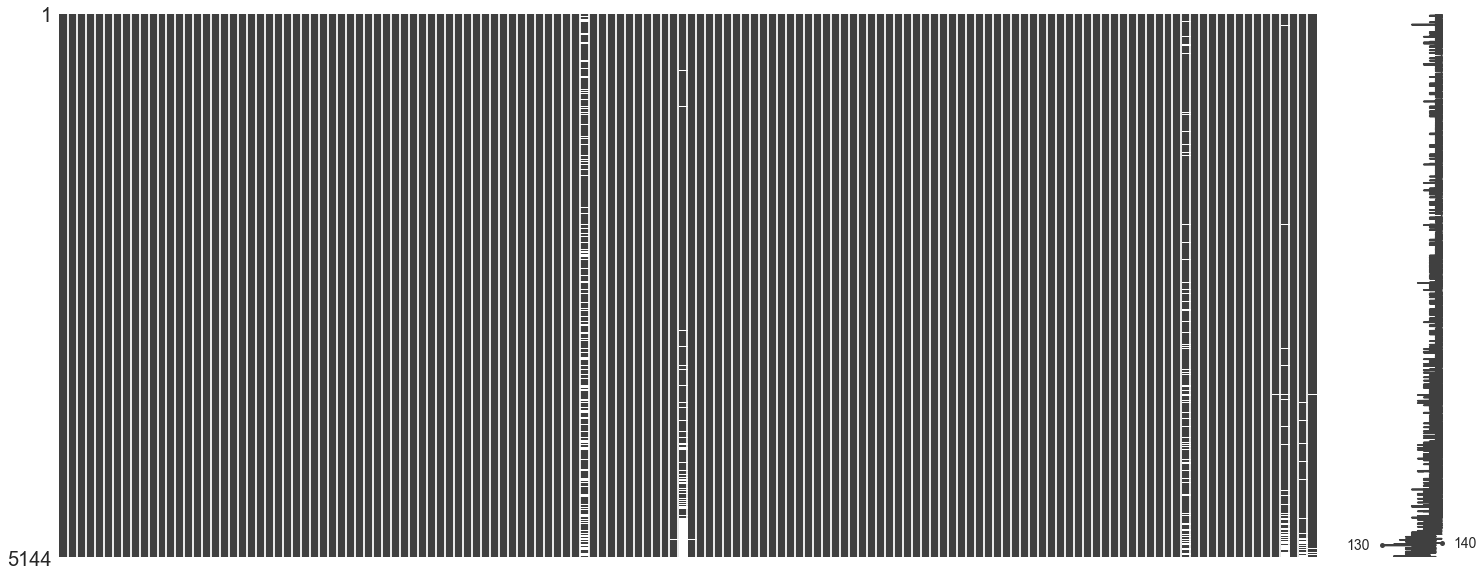

In [14]:
## Sanity check again

#pd.set_option('max_rows',None)
#print(df_fill.isna().sum())

mg.matrix(df_fill);

> Its getting better bit by bit!

#### Filling Reach/Height/Weight

In [15]:
## Using .groupby to find aggregrate stats for groups
height_grouped = df_fill.groupby('R_Height_cms').agg('mean')
display(height_grouped.head())

## Making dictionary of reach values acc. to height grouping
reach_by_height = dict(height_grouped['R_Reach_cms'])
display(reach_by_height)

,title_bout,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_BODY_att,B_avg_BODY_landed,B_avg_CLINCH_att,B_avg_CLINCH_landed,B_avg_DISTANCE_att,...,R_win_by_Decision_Split,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_wins,R_Reach_cms,R_Weight_lbs,B_age,R_age
R_Height_cms,,,,,,,,,,,,,,,,,,,,,
152.40,0.000000,3.000000,0.000000,0.500000,0.0,8.750000,6.250000,8.500000,6.500000,71.750000,...,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,152.400000,115.000000,26.500000,28.000000
154.94,0.080000,3.160000,0.280000,0.880000,0.0,12.076762,8.322000,14.464000,10.693238,64.446762,...,0.400000,1.760000,0.160000,0.680000,0.000000,3.000000,157.480000,115.000000,29.160000,26.320000
157.48,0.000000,3.000000,0.714286,0.142857,0.0,3.214286,2.023810,3.190476,1.904762,53.333333,...,0.000000,0.428571,0.000000,0.285714,0.000000,0.714286,160.745714,117.857143,29.714286,28.285714
160.02,0.190476,3.428571,0.349206,1.111111,0.0,12.551494,7.979525,8.324463,5.644547,64.666361,...,0.507937,2.301587,1.238095,0.587302,0.095238,4.730159,164.858095,125.317460,28.349206,29.746032
162.56,0.035088,3.105263,0.324561,0.754386,0.0,9.453106,6.392813,8.522069,5.935818,56.728987,...,0.219298,1.666667,0.473684,0.394737,0.000000,2.754386,164.987611,124.561404,28.552632,29.245614


{152.4: 152.4,
 154.94: 157.48000000000002,
 157.48000000000005: 160.74571428571429,
 160.02: 164.85809523809536,
 162.56: 164.98761061946905,
 165.1: 167.62145985401455,
 167.64: 170.91507163323794,
 170.18: 175.6790572390578,
 172.72: 177.22211640211643,
 175.26: 179.98928870292895,
 177.8: 182.0478372591003,
 180.34: 185.68854625550645,
 182.88: 187.4072538860109,
 185.42: 189.98413080895023,
 187.96: 192.71544444444447,
 190.5: 196.16033112582835,
 193.04: 201.5994520547946,
 195.58: 199.31062499999993,
 198.12: 200.83517241379303,
 200.66: 205.74,
 203.2: 203.20000000000002,
 208.28: nan,
 210.82: 213.3600000000001}

In [16]:
## Same as above but targeting Height values to be filled
reach_grouped = df_fill.groupby('R_Reach_cms').agg('mean')
#display(reach_grouped)

height_by_reach = dict(reach_grouped['R_Height_cms'])
display(height_by_reach)

{152.4: 154.3755555555556,
 157.48: 157.3106666666667,
 160.02: 160.91370370370385,
 162.56: 163.75944444444448,
 165.1: 165.78914728682167,
 167.64: 166.22531645569606,
 170.18: 167.6562820512819,
 172.72: 170.93834532374112,
 175.26: 172.94302439024398,
 177.8: 174.06380761523002,
 180.34: 175.9309433962269,
 182.88: 179.5954137115838,
 185.42: 180.57549668874137,
 187.96: 183.25398773006103,
 190.5: 184.52804651162717,
 193.04: 185.64592991913685,
 195.58: 188.2499999999996,
 198.12: 189.06991596638656,
 200.66: 190.8122950819671,
 203.2: 192.7577777777779,
 205.74: 193.73272727272723,
 208.28: 194.30999999999997,
 210.82: 193.04,
 213.36: 201.29499999999996}

In [17]:
## Targeting weight values to be filled
weight_cls_grouped = df_fill.groupby('weight_class').agg('mean')
#display(weight_cls_grouped)

weight_by_class = dict(weight_cls_grouped['R_Weight_lbs'])
display(weight_by_class)

{'Bantamweight': 134.5778364116095,
 'Catch Weight': 183.5,
 'Featherweight': 145.80316742081448,
 'Flyweight': 127.13903743315508,
 'Heavyweight': 245.10453648915188,
 'Light Heavyweight': 202.5309381237525,
 'Lightweight': 155.99291497975707,
 'Middleweight': 184.72137931034482,
 'Open Weight': 224.5164835164835,
 'Welterweight': 170.312693498452,
 "Women's Bantamweight": 133.64864864864865,
 "Women's Featherweight": 145.0,
 "Women's Flyweight": 125.0,
 "Women's Strawweight": 116.53846153846153}

> At this point I have the corresponding values for average height and reach based upon each other respectively in addition to average weight by weight class in dictionaries. Next I will use the .map() method to apply them appropriately.

In [18]:
## Scaffolding for filling of values

#df.B = df.B.fillna(df.A.map(dict))

In [19]:
cols1 = ['B_Reach_cms', 'R_Reach_cms']

for col in cols1:
    df_fill[col] = df_fill[col].fillna(df_fill['R_Height_cms'].map(reach_by_height))

In [20]:
cols2 = ['B_Height_cms', 'R_Height_cms']

for col in cols2:
    df_fill[col] = df_fill[col].fillna(df_fill['R_Reach_cms'].map(height_by_reach))

In [21]:
cols3 = ['B_Weight_lbs', 'R_Weight_lbs']

for col in cols3:
    df_fill[col] = df_fill[col].fillna(df_fill['weight_class'].map(weight_by_class))

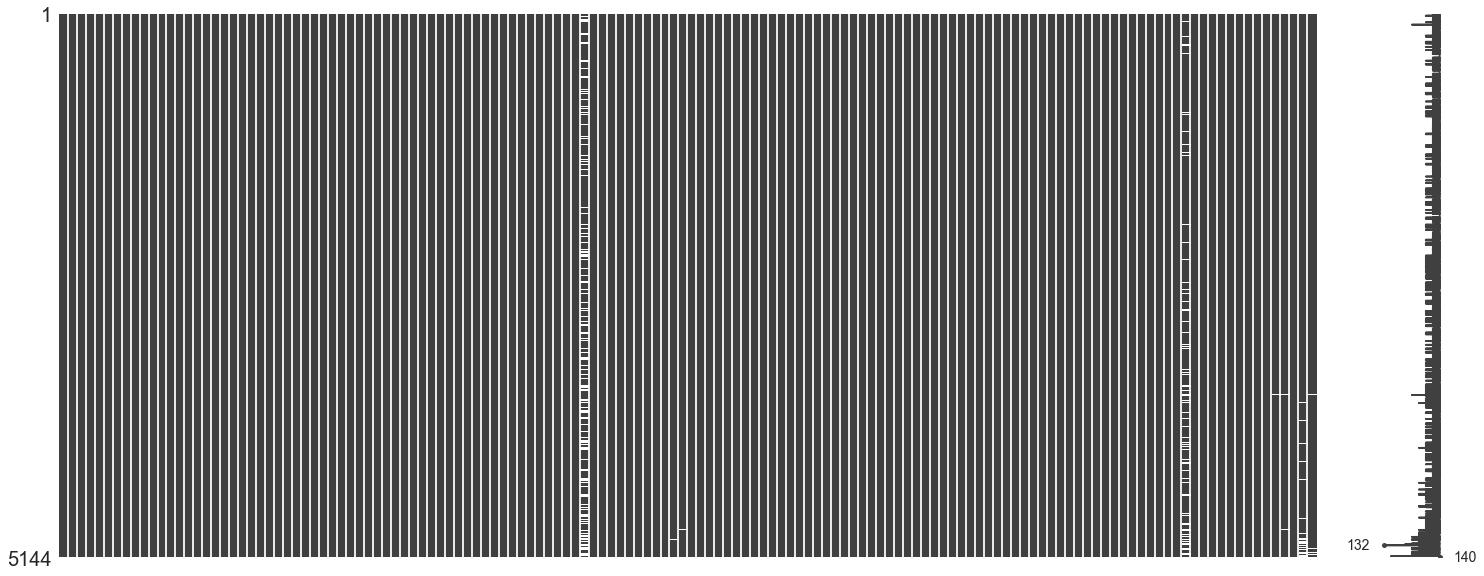

In [22]:
mg.matrix(df_fill);

> Needing to fill values that did not have Height nor Reach to fill from dictionary

In [23]:
## Locate the NAs Red corner

df_fill.loc[(pd.isnull(df_fill.R_Height_cms)), 'R_Height_cms']

103    NaN
3607   NaN
5029   NaN
5132   NaN
Name: R_Height_cms, dtype: float64

In [24]:
## Verifying both columns are NA

list2 = [103, 3607, 5029, 5132]
for idx in list2:
    display(df_fill.iloc[idx][['R_Height_cms', 'R_Reach_cms']])

R_Height_cms    NaN
R_Reach_cms     NaN
Name: 103, dtype: object

R_Height_cms    NaN
R_Reach_cms     NaN
Name: 3607, dtype: object

R_Height_cms    NaN
R_Reach_cms     NaN
Name: 5029, dtype: object

R_Height_cms    NaN
R_Reach_cms     NaN
Name: 5132, dtype: object

In [25]:
## Locate the NAs Blue corner

df_fill.loc[(pd.isnull(df_fill.B_Height_cms)), 'B_Height_cms']

4978   NaN
5020   NaN
5029   NaN
5134   NaN
Name: B_Height_cms, dtype: float64

In [26]:
## Same as above

list3 = [4978, 5020, 5029, 5134]
for idx in list3:
    display(df_fill.iloc[idx][['B_Height_cms', 'B_Reach_cms']])

B_Height_cms        NaN
B_Reach_cms     185.689
Name: 4978, dtype: object

B_Height_cms        NaN
B_Reach_cms     179.989
Name: 5020, dtype: object

B_Height_cms    NaN
B_Reach_cms     NaN
Name: 5029, dtype: object

B_Height_cms        NaN
B_Reach_cms     192.715
Name: 5134, dtype: object

In [27]:
## Sanity check on specific index/help to make strategy to fill others

print(df_fill.iloc[3607].isna().sum())
df_fill.iloc[3607][['weight_class', 'R_Reach_cms', 'R_Height_cms', 'B_Reach_cms', 'B_Height_cms']]

4


weight_class    Light Heavyweight
R_Reach_cms                   NaN
R_Height_cms                  NaN
B_Reach_cms                 190.5
B_Height_cms                190.5
Name: 3607, dtype: object

In [28]:
## Displaying values to fill according to each fight's weight class
## I have no other body attribute to go off of. 

display(weight_cls_grouped[['R_Reach_cms', 'R_Height_cms', 'B_Reach_cms', 'B_Height_cms']].iloc[8])
display(weight_cls_grouped[['R_Reach_cms', 'R_Height_cms', 'B_Reach_cms', 'B_Height_cms']].iloc[6])
display(weight_cls_grouped[['R_Reach_cms', 'R_Height_cms', 'B_Reach_cms', 'B_Height_cms']].iloc[5])
display(weight_cls_grouped[['R_Reach_cms', 'R_Height_cms', 'B_Reach_cms', 'B_Height_cms']].iloc[4])

R_Reach_cms     186.690000
R_Height_cms    186.424835
B_Reach_cms     182.880000
B_Height_cms    184.912000
Name: Open Weight, dtype: float64

R_Reach_cms     181.063807
R_Height_cms    176.481154
B_Reach_cms     181.392244
B_Height_cms    176.603492
Name: Lightweight, dtype: float64

R_Reach_cms     192.831803
R_Height_cms    187.137040
B_Reach_cms     192.145874
B_Height_cms    186.674821
Name: Light Heavyweight, dtype: float64

R_Reach_cms     196.393271
R_Height_cms    189.773570
B_Reach_cms     196.227178
B_Height_cms    189.827352
Name: Heavyweight, dtype: float64

> Values to fill:
* Row 103 : Light Heavy R_Reach/Height ..... 2
* Row 3607: Light Heavy R_Reach/Height .... 2
* Row 4978: Lightweight B_Height ................ 1
* Row 5020: Heavyweight B_Height .............. 1
* Row 5029: Lightweight B/R_Reach/Height .. 4
* Row 5132: Open Weight B/R_Reach:R_Height . 3
* Row 5134: Open Weight B_Height ........... 1

In [29]:
## Creating dictionaries according to indices to fill the NAs from values above

val_R_rch = {103: 192.831803, 3607: 192.831803, 5029: 181.063807, 5132: 186.690000}
val_R_hgt = {103: 187.137040, 3607: 187.137040, 5029: 176.481154, 5132: 186.424835}

val_B_rch = {5029: 181.392244, 5132: 182.880000}
val_B_hgt = {4978: 176.603492, 5020: 189.827352, 5029: 176.603492, 5134: 184.912000}

## Filling each column acc. to dictionaries above
cols4 = ['R_Reach_cms', 'R_Height_cms', 'B_Reach_cms', 'B_Height_cms']

df_fill[cols4[0]] = df_fill[cols4[0]].fillna(val_R_rch)
df_fill[cols4[1]] = df_fill[cols4[1]].fillna(val_R_hgt)
df_fill[cols4[2]] = df_fill[cols4[2]].fillna(val_B_rch)
df_fill[cols4[3]] = df_fill[cols4[3]].fillna(val_B_hgt)

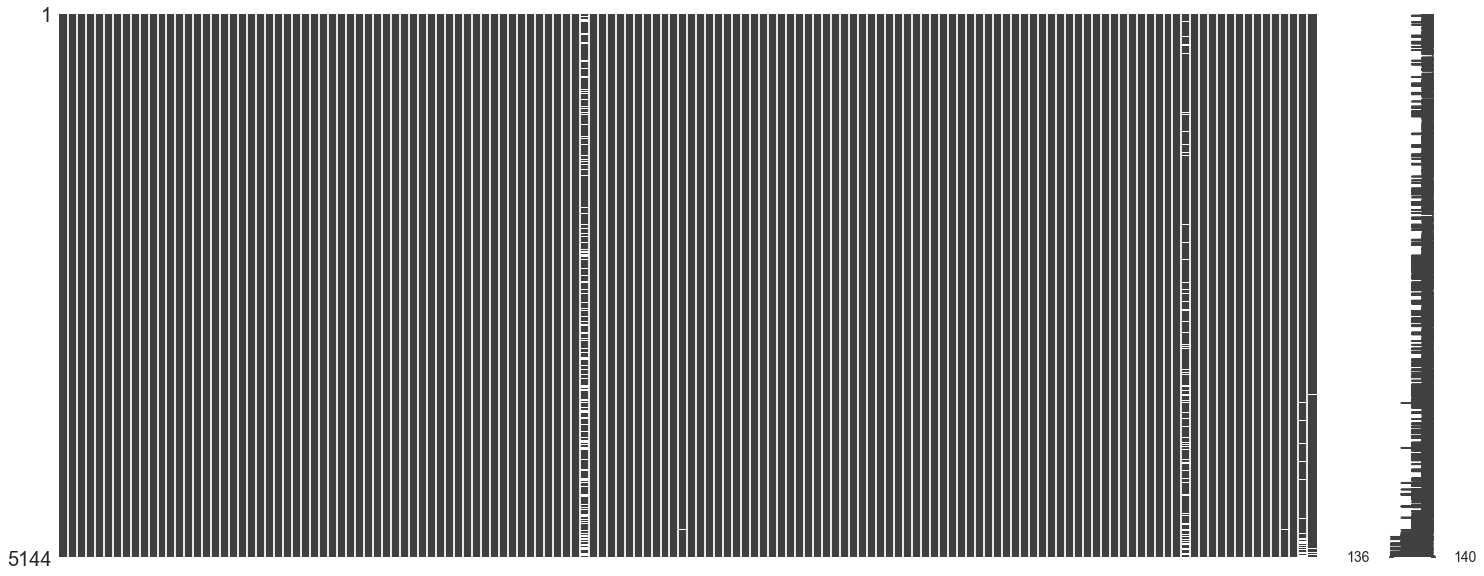

In [30]:
mg.matrix(df_fill);

In [31]:
#pd.set_option('max_rows', None)

In [32]:
df_fill.isna().sum()

Winner                            0
title_bout                        0
weight_class                      0
no_of_rounds                      0
B_current_lose_streak             0
B_current_win_streak              0
B_draw                            0
B_avg_BODY_att                    0
B_avg_BODY_landed                 0
B_avg_CLINCH_att                  0
B_avg_CLINCH_landed               0
B_avg_DISTANCE_att                0
B_avg_DISTANCE_landed             0
B_avg_GROUND_att                  0
B_avg_GROUND_landed               0
B_avg_HEAD_att                    0
B_avg_HEAD_landed                 0
B_avg_KD                          0
B_avg_LEG_att                     0
B_avg_LEG_landed                  0
B_avg_PASS                        0
B_avg_REV                         0
B_avg_SIG_STR_att                 0
B_avg_SIG_STR_landed              0
B_avg_SIG_STR_pct                 0
B_avg_SUB_ATT                     0
B_avg_TD_att                      0
B_avg_TD_landed             

> Almost there!

In [33]:
## Finding the rest

display(df_fill.loc[(pd.isnull(df_fill.R_Reach_cms)), 'R_Reach_cms'])
display(df_fill.loc[(pd.isnull(df_fill.B_Reach_cms)), 'B_Reach_cms'])

4800   NaN
4814   NaN
4883   NaN
Name: R_Reach_cms, dtype: float64

4800   NaN
4814   NaN
4883   NaN
Name: B_Reach_cms, dtype: float64

> I am going to find the weight classes and confirm the values I need to fill.

In [34]:
print(df_fill.iloc[4800].isna().sum())
df_fill.iloc[4800][['weight_class', 'R_Reach_cms', 'B_Reach_cms']]

2


weight_class    Heavyweight
R_Reach_cms             NaN
B_Reach_cms             NaN
Name: 4800, dtype: object

In [35]:
print(df_fill.iloc[4814].isna().sum())
df_fill.iloc[4814][['weight_class', 'R_Reach_cms', 'B_Reach_cms']]

2


weight_class    Heavyweight
R_Reach_cms             NaN
B_Reach_cms             NaN
Name: 4814, dtype: object

In [36]:
print(df_fill.iloc[4883].isna().sum())
df_fill.iloc[4883][['weight_class', 'R_Reach_cms', 'B_Reach_cms']]

3


weight_class    Heavyweight
R_Reach_cms             NaN
B_Reach_cms             NaN
Name: 4883, dtype: object

In [37]:
## Grabbing avgs. from groupby to fill with

display(weight_cls_grouped[['R_Reach_cms', 'B_Reach_cms']].iloc[4])

R_Reach_cms    196.393271
B_Reach_cms    196.227178
Name: Heavyweight, dtype: float64

In [38]:
## Same as above

val_R_rch2 = {4800: 196.393271, 4814: 196.393271, 4883: 196.393271}
val_B_rch2 = {4800: 196.227178, 4814: 196.227178, 4883: 196.227178}

## For reference
#cols4 = ['R_Reach_cms', 'R_Height_cms', 'B_Reach_cms', 'B_Height_cms']

df_fill[cols4[0]] = df_fill[cols4[0]].fillna(val_R_rch2)
df_fill[cols4[2]] = df_fill[cols4[2]].fillna(val_B_rch2)

In [39]:
#pd.set_option('max_rows', None)

In [40]:
df_fill.isna().sum()

Winner                            0
title_bout                        0
weight_class                      0
no_of_rounds                      0
B_current_lose_streak             0
B_current_win_streak              0
B_draw                            0
B_avg_BODY_att                    0
B_avg_BODY_landed                 0
B_avg_CLINCH_att                  0
B_avg_CLINCH_landed               0
B_avg_DISTANCE_att                0
B_avg_DISTANCE_landed             0
B_avg_GROUND_att                  0
B_avg_GROUND_landed               0
B_avg_HEAD_att                    0
B_avg_HEAD_landed                 0
B_avg_KD                          0
B_avg_LEG_att                     0
B_avg_LEG_landed                  0
B_avg_PASS                        0
B_avg_REV                         0
B_avg_SIG_STR_att                 0
B_avg_SIG_STR_landed              0
B_avg_SIG_STR_pct                 0
B_avg_SUB_ATT                     0
B_avg_TD_att                      0
B_avg_TD_landed             

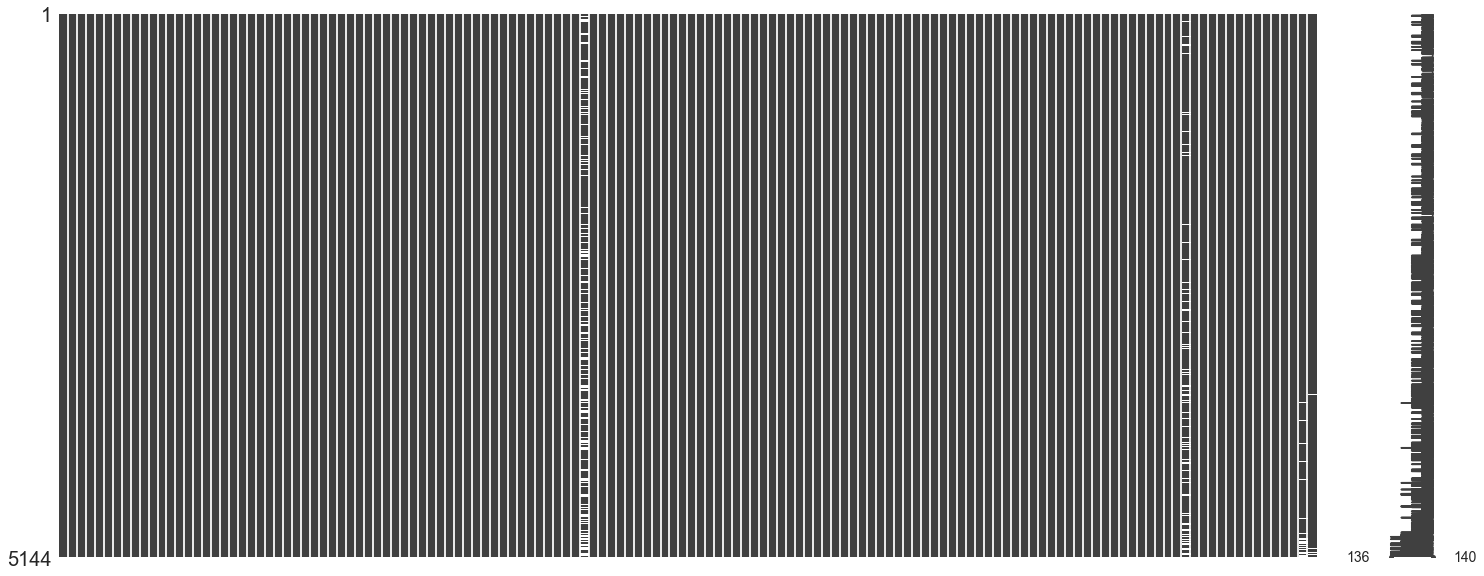

In [41]:
mg.matrix(df_fill);

#### Filling Age

In [42]:
## Creating variable to hold age mean for filling
print(df_fill[['B_age', 'R_age']].mean())

## Taking midpoint between two columns
age_mean = (df_fill['B_age'].mean() + df_fill['R_age'].mean()) / 2
age_mean

B_age    29.171963
R_age    29.442323
dtype: float64


29.307142913702563

In [43]:
## Filling with mean age

df_fill['B_age'] = df_fill['B_age'].fillna(age_mean)
df_fill['R_age'] = df_fill['R_age'].fillna(age_mean)

> Filled age with mean, looking at those rows, generally speaking, it appears that first time fighters are the culprit again. This may have to do with the lack of preplanning or rescheduling due to injury.

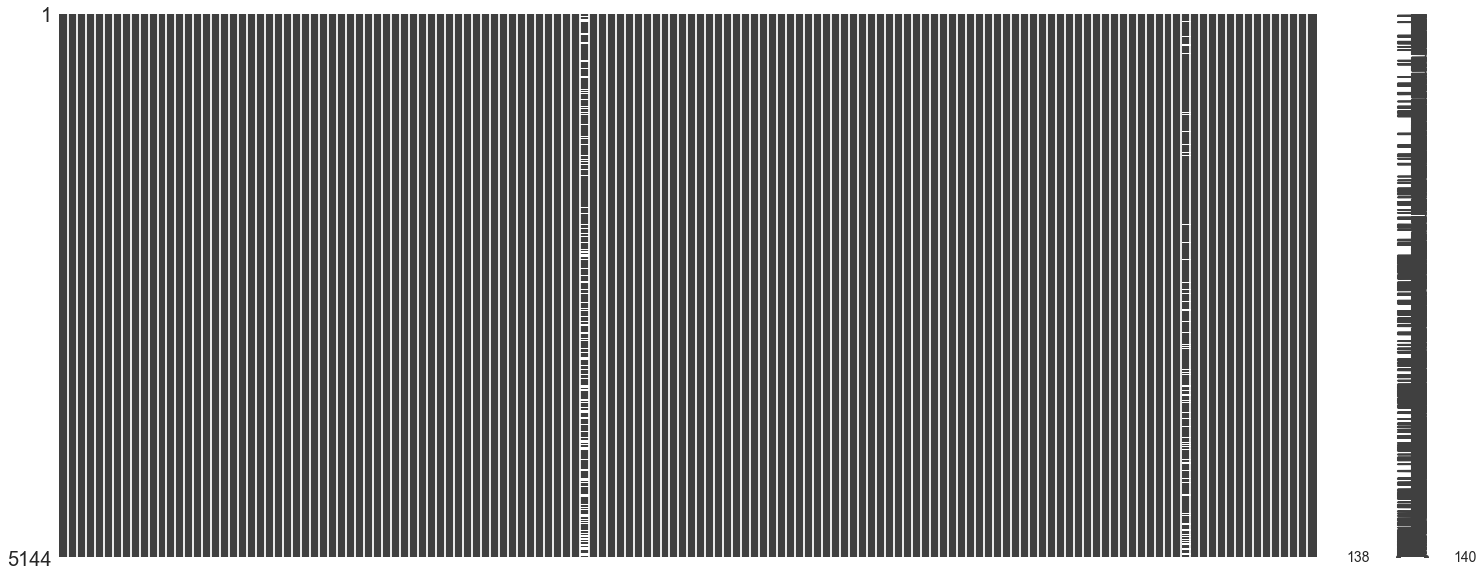

In [44]:
## Visual check

mg.matrix(df_fill);

#### Filling Total Time Fought

In [45]:
## Filling with zeros for first time fighters

df_fill['R_total_time_fought(seconds)'] = df_fill['R_total_time_fought(seconds)'].fillna(0)
df_fill['B_total_time_fought(seconds)'] = df_fill['B_total_time_fought(seconds)'].fillna(0)

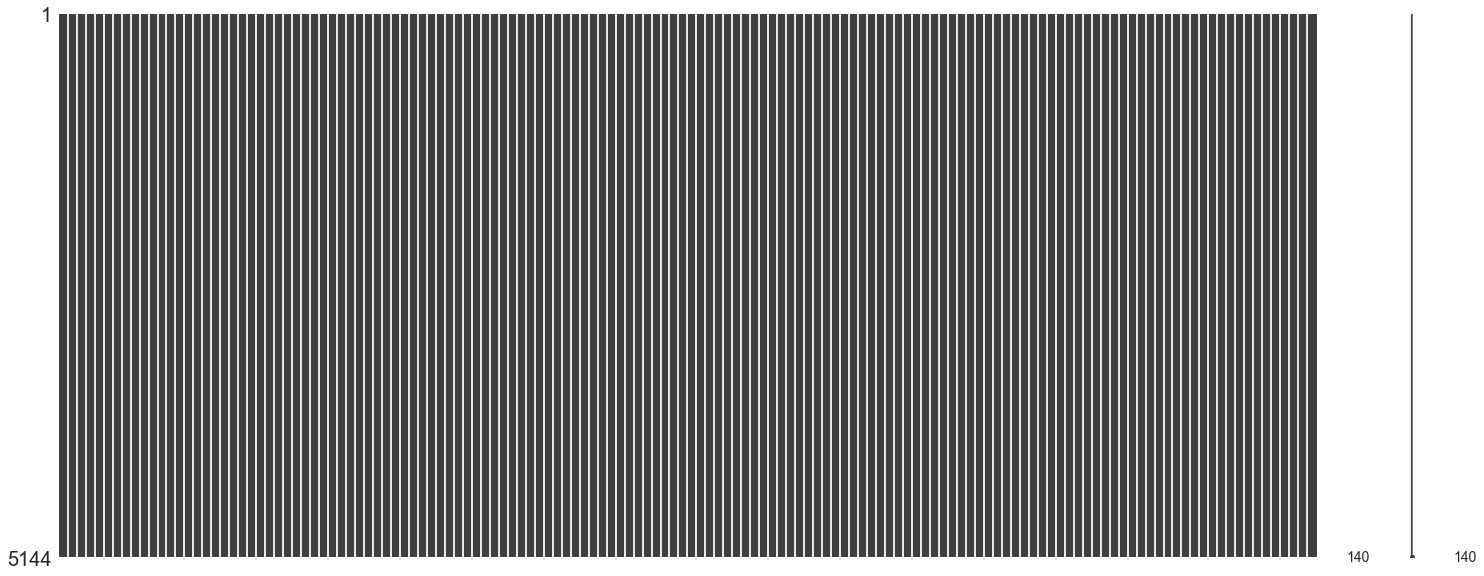

In [46]:
## Null check

#print(df_fill.isna().sum())
mg.matrix(df_fill);

> Finally done!

#### Encoding Categorical Features

In [47]:
## Check for categories and peek at Df

print(df_fill.info())
df_fill.select_dtypes(['object', 'bool']).head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5144 entries, 0 to 5143
Columns: 140 entries, Winner to R_age
dtypes: bool(1), float64(134), int64(1), object(4)
memory usage: 5.5+ MB
None


,Winner,title_bout,weight_class,B_Stance,R_Stance
0,Red,True,Bantamweight,Orthodox,Orthodox
1,Red,True,Women's Flyweight,Orthodox,Southpaw
2,Red,False,Lightweight,Orthodox,Orthodox
3,Blue,False,Bantamweight,Switch,Orthodox
4,Blue,False,Heavyweight,Southpaw,Southpaw


In [48]:
## Encoding categorical columns

cat_df = df_fill.select_dtypes(['object', 'bool']).copy()
dummy_df = pd.get_dummies(cat_df)

## Dropping title to reintroduce as an int and Winner as label encoded

dummy_df.drop(columns=['title_bout', 'Winner_Blue', 'Winner_Draw', 'Winner_Red'], inplace=True)
dummy_df.head()

,weight_class_Bantamweight,weight_class_Catch Weight,weight_class_Featherweight,weight_class_Flyweight,weight_class_Heavyweight,weight_class_Light Heavyweight,weight_class_Lightweight,weight_class_Middleweight,weight_class_Open Weight,weight_class_Welterweight,...,B_Stance_Open Stance,B_Stance_Orthodox,B_Stance_Sideways,B_Stance_Southpaw,B_Stance_Switch,R_Stance_Open Stance,R_Stance_Orthodox,R_Stance_Sideways,R_Stance_Southpaw,R_Stance_Switch
0,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [49]:
## Series to label encoding winner column

win_series = cat_df['Winner'].copy()
dict_win = {'Draw': 0, 'Red': 1, 'Blue': 2}
win_series = win_series.map(dict_win)
win_series.value_counts()

1    3470
2    1591
0      83
Name: Winner, dtype: int64

In [50]:
## Same as winner column

title_series = cat_df['title_bout'].copy()
dict_title = {True: 1, False: 0}
title_series = title_series.map(dict_title)
title_series.head()

0    1
1    1
2    0
3    0
4    0
Name: title_bout, dtype: int64

In [51]:
## Helper for code length

drop_cols = ['Winner', 'title_bout', 'B_Stance', 'R_Stance', 'weight_class']

In [52]:
## Putting it back together

df_full = pd.concat([df_fill.drop(columns=drop_cols), win_series, title_series, dummy_df], axis=1)
df_full.head()

,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_BODY_att,B_avg_BODY_landed,B_avg_CLINCH_att,B_avg_CLINCH_landed,B_avg_DISTANCE_att,B_avg_DISTANCE_landed,...,B_Stance_Open Stance,B_Stance_Orthodox,B_Stance_Sideways,B_Stance_Southpaw,B_Stance_Switch,R_Stance_Open Stance,R_Stance_Orthodox,R_Stance_Sideways,R_Stance_Southpaw,R_Stance_Switch
0,5,0.0,4.0,0.0,9.200000,6.000000,0.200000,0.000000,62.600000,20.600000,...,0,1,0,0,0,0,1,0,0,0
1,5,0.0,3.0,0.0,14.600000,9.100000,11.800000,7.300000,124.700000,42.100000,...,0,1,0,0,0,0,0,0,1,0
2,3,0.0,3.0,0.0,15.354839,11.322581,6.741935,4.387097,84.741935,38.580645,...,0,1,0,0,0,0,1,0,0,0
3,3,0.0,4.0,0.0,17.000000,14.000000,13.750000,11.000000,109.500000,48.750000,...,0,0,0,0,1,0,1,0,0,0
4,3,0.0,1.0,0.0,17.000000,14.500000,2.500000,2.000000,201.000000,59.500000,...,0,0,0,1,0,0,0,0,1,0


In [53]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5144 entries, 0 to 5143
Columns: 161 entries, no_of_rounds to R_Stance_Switch
dtypes: float64(134), int64(3), uint8(24)
memory usage: 5.5 MB


In [54]:
## Set up for quick visual check of multicollinearity

corr_test = df_full.corr()

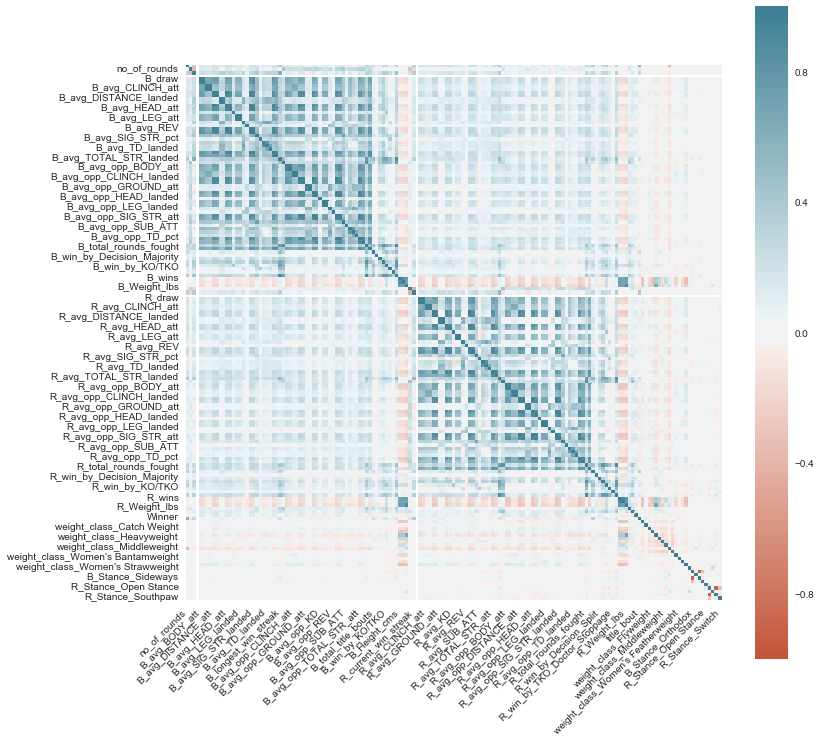

In [55]:
fig, ax = plt.subplots(figsize=(12,12))

sns.heatmap(corr_test, vmin=-1, vmax=1, center=0, 
            cmap=sns.diverging_palette(20, 220, n=200), square=True)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, 
                   horizontalalignment='right');

> AVGS show some correlation, but nothing demonstrates a strong connection to the winner category

### Final Prep for Model

#### Creating a Scaled Version

> In order to explore different types of models, it is imperative to scale data to allow for proper calculations.

In [56]:
## Separate features from target to train-test split

X = df_full.drop('Winner', axis=1).copy()
y = df_full['Winner'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22)

> I performed the split *prior* to scaling to prevent leakage into my test data set

In [57]:
## Verifying class balance is roughly the same

print('Original Class Balance')
display(y.value_counts(normalize=True))
print('y_train Class Balance')
display(y_train.value_counts(normalize=True))
print('y_test Class Balance')
display(y_test.value_counts(normalize=True))

Original Class Balance


1    0.674572
2    0.309292
0    0.016135
Name: Winner, dtype: float64

y_train Class Balance


1    0.680404
2    0.304044
0    0.015552
Name: Winner, dtype: float64

y_test Class Balance


1    0.657076
2    0.325039
0    0.017885
Name: Winner, dtype: float64

In [58]:
## Instantiate scaler and fit_transform to training only

scaler = MinMaxScaler()

X_train_sca = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns,
                           index=X_train.index)
X_test_sca = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, 
                          index=X_test.index)

## Check for scaling

display(X_train_sca.head())
display(X_train_sca.describe().loc[['min', 'max']])
display(X_test_sca.head())
display(X_test_sca.describe().loc[['min', 'max']])

,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_BODY_att,B_avg_BODY_landed,B_avg_CLINCH_att,B_avg_CLINCH_landed,B_avg_DISTANCE_att,B_avg_DISTANCE_landed,...,B_Stance_Open Stance,B_Stance_Orthodox,B_Stance_Sideways,B_Stance_Southpaw,B_Stance_Switch,R_Stance_Open Stance,R_Stance_Orthodox,R_Stance_Sideways,R_Stance_Southpaw,R_Stance_Switch
2898,1.0,0.0,0.076923,0.0,0.167347,0.164103,0.062069,0.050000,0.325461,0.262009,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1358,0.5,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2510,0.5,0.0,0.230769,0.0,0.292517,0.247863,0.045977,0.039216,0.554736,0.509461,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1181,0.5,0.0,0.230769,0.0,0.119898,0.073718,0.043103,0.034926,0.193727,0.117904,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4583,0.5,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_BODY_att,B_avg_BODY_landed,B_avg_CLINCH_att,B_avg_CLINCH_landed,B_avg_DISTANCE_att,B_avg_DISTANCE_landed,...,B_Stance_Open Stance,B_Stance_Orthodox,B_Stance_Sideways,B_Stance_Southpaw,B_Stance_Switch,R_Stance_Open Stance,R_Stance_Orthodox,R_Stance_Sideways,R_Stance_Southpaw,R_Stance_Switch
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_BODY_att,B_avg_BODY_landed,B_avg_CLINCH_att,B_avg_CLINCH_landed,B_avg_DISTANCE_att,B_avg_DISTANCE_landed,...,B_Stance_Open Stance,B_Stance_Orthodox,B_Stance_Sideways,B_Stance_Southpaw,B_Stance_Switch,R_Stance_Open Stance,R_Stance_Orthodox,R_Stance_Sideways,R_Stance_Southpaw,R_Stance_Switch
1899,0.5,0.166667,0.000000,0.0,0.104308,0.095442,0.075990,0.070261,0.114801,0.116934,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4061,0.5,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1831,1.0,0.000000,0.384615,0.0,0.061224,0.043393,0.045977,0.032805,0.150724,0.104132,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1788,0.5,0.166667,0.000000,0.0,0.215743,0.179487,0.067323,0.046218,0.191355,0.193387,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5088,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_BODY_att,B_avg_BODY_landed,B_avg_CLINCH_att,B_avg_CLINCH_landed,B_avg_DISTANCE_att,B_avg_DISTANCE_landed,...,B_Stance_Open Stance,B_Stance_Orthodox,B_Stance_Sideways,B_Stance_Southpaw,B_Stance_Switch,R_Stance_Open Stance,R_Stance_Orthodox,R_Stance_Sideways,R_Stance_Southpaw,R_Stance_Switch
min,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.0,0.833333,0.615385,0.0,0.979592,0.717949,0.54023,0.544118,1.0,1.135371,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0


### Fitting Vanilla Models

In [59]:
## Instantiating a bunch of classifiers to test

tree_clf = DecisionTreeClassifier(class_weight='balanced')
rf_clf = RandomForestClassifier(class_weight='balanced')
log_clf = LogisticRegression(C=1e9, class_weight='balanced',
                             multi_class='multinomial')
knn_clf = KNeighborsClassifier()
ada_clf = AdaBoostClassifier()
grad_clf = GradientBoostingClassifier()
xgb_clf = xgb.XGBClassifier(objective='multi:softprob', num_class=3)

LogisticRegression(C=1000000000.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)

Classification Report Test
              precision    recall  f1-score   support

           0       0.02      0.17      0.03        23
           1       0.80      0.56      0.66       845
           2       0.49      0.55      0.52       418

    accuracy                           0.55      1286
   macro avg       0.44      0.43      0.40      1286
weighted avg       0.68      0.55      0.60      1286



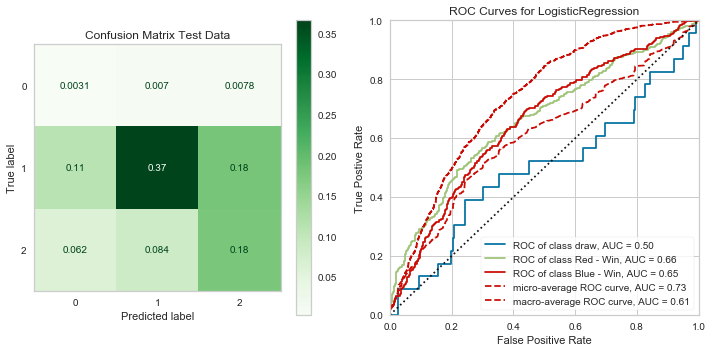

---- Timer stopped at: 04/27/2020 - 08:43 PM ----
---- Time elasped: 0:00:01.132971 ----


DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Classification Report Test
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.68      0.70      0.69       845
           2       0.38      0.36      0.37       418

    accuracy                           0.58      1286
   macro avg       0.36      0.36      0.36      1286
weighted avg       0.57      0.58      0.58      1286



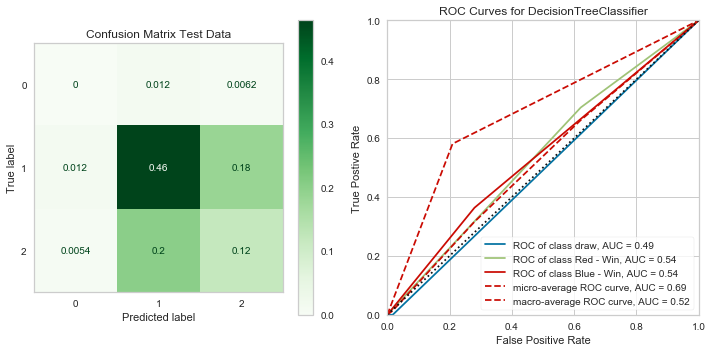

---- Timer stopped at: 04/27/2020 - 08:43 PM ----
---- Time elasped: 0:00:01.170899 ----


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Classification Report Test
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.67      0.97      0.79       845
           2       0.60      0.09      0.16       418

    accuracy                           0.67      1286
   macro avg       0.42      0.35      0.32      1286
weighted avg       0.64      0.67      0.57      1286



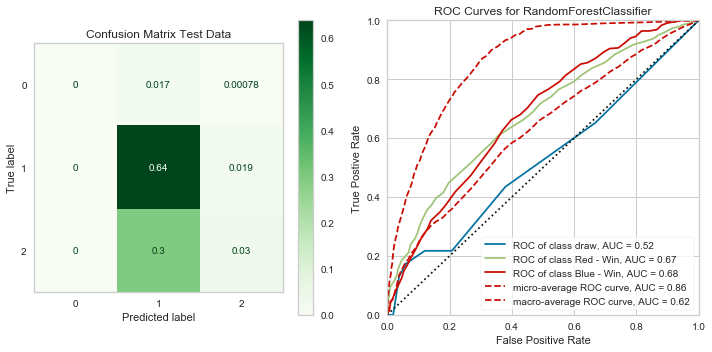

---- Timer stopped at: 04/27/2020 - 08:43 PM ----
---- Time elasped: 0:00:03.938470 ----


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

Classification Report Test
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.68      0.82      0.74       845
           2       0.41      0.26      0.32       418

    accuracy                           0.62      1286
   macro avg       0.36      0.36      0.35      1286
weighted avg       0.58      0.62      0.59      1286



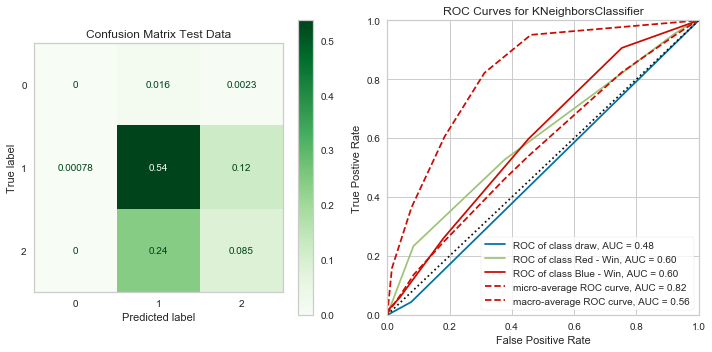

---- Timer stopped at: 04/27/2020 - 08:43 PM ----
---- Time elasped: 0:00:19.038378 ----


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

Classification Report Test
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.68      0.92      0.78       845
           2       0.51      0.18      0.26       418

    accuracy                           0.66      1286
   macro avg       0.40      0.36      0.35      1286
weighted avg       0.61      0.66      0.60      1286



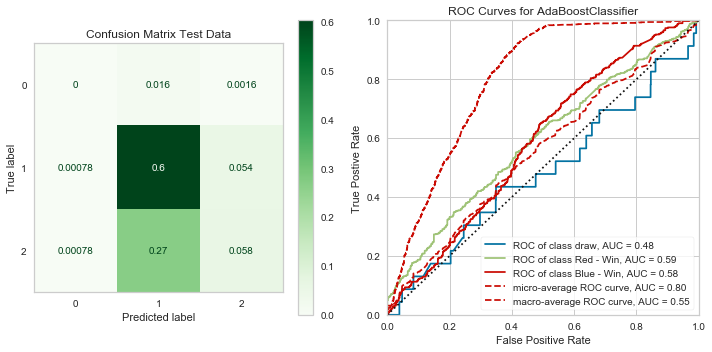

---- Timer stopped at: 04/27/2020 - 08:43 PM ----
---- Time elasped: 0:00:02.523258 ----


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

Classification Report Test
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.69      0.91      0.79       845
           2       0.54      0.22      0.32       418

    accuracy                           0.67      1286
   macro avg       0.41      0.38      0.37      1286
weighted avg       0.63      0.67      0.62      1286



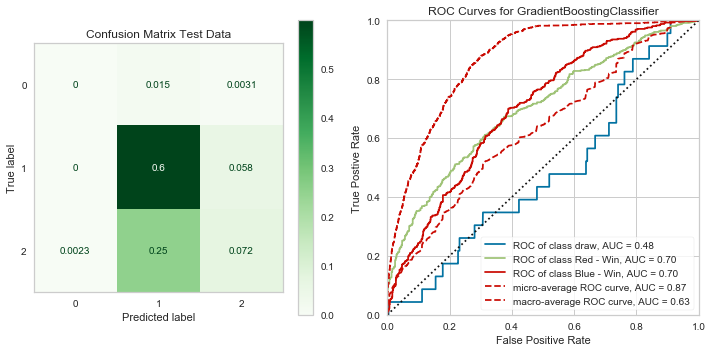

---- Timer stopped at: 04/27/2020 - 08:44 PM ----
---- Time elasped: 0:00:26.651734 ----


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, num_class=3, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

Classification Report Test
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.69      0.92      0.79       845
           2       0.55      0.21      0.31       418

    accuracy                           0.67      1286
   macro avg       0.41      0.38      0.36      1286
weighted avg       0.63      0.67      0.62      1286



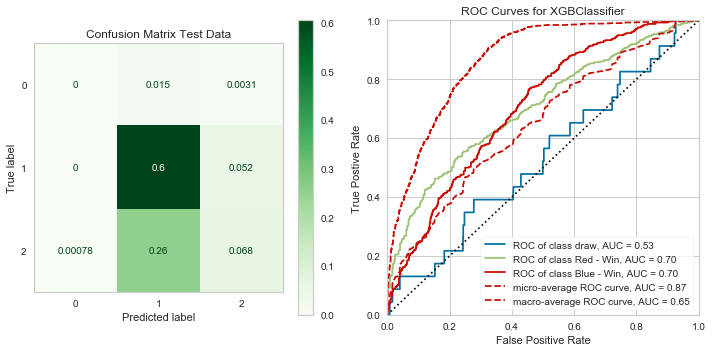

---- Timer stopped at: 04/27/2020 - 08:44 PM ----
---- Time elasped: 0:00:07.353348 ----


In [60]:
## Set up to time models/check performance

mods = [log_clf, tree_clf, rf_clf, knn_clf, ada_clf, grad_clf, xgb_clf]
mod_labs = ['log_clf', 'tree_clf', 'rf_clf', 'knn_clf', 'ada_clf', 'grad_clf', 'xgb_clf']
t = dlf.Timer()
labs = ['draw', 'Red - Win', 'Blue - Win']

times = dlf.time_models(X_train_sca, X_test_sca, y_train, y_test, mods, mod_labs, t, cls_lab=labs)

In [61]:
# Check for run-times

times_sorted = sorted(times.items(), key=lambda x: x[1])
times_sorted

[('log_clf', 1.132971),
 ('tree_clf', 1.170899),
 ('ada_clf', 2.523258),
 ('rf_clf', 3.93847),
 ('xgb_clf', 7.353348),
 ('knn_clf', 19.038378),
 ('grad_clf', 26.651734)]

> I have good accuracy, but it is misleading because it is almost always guessing class 1, which due to class imbalances is likely to be right when it does. Next I will try and remedy this.

#### SMOTE

> My classifiers may be missing so much due to the class imbalances for the categories, I am going to oversample the minority classes in order to compensate. 

In [62]:
print('Original class distribution: \n')
print(y_train.value_counts())

smote = SMOTE()
X_trn_sca_resmp, y_trn_resmp = smote.fit_sample(X_train_sca, y_train)
X_trn_sca_resmp = pd.DataFrame(X_trn_sca_resmp, columns=X_train_sca.columns)

print('-----------------------------------------')
print('Resampled class distribution: \n')
print(pd.Series(y_trn_resmp).value_counts()) 

Original class distribution: 

1    2625
2    1173
0      60
Name: Winner, dtype: int64
-----------------------------------------
Resampled class distribution: 

2    2625
1    2625
0    2625
dtype: int64


LogisticRegression(C=1000000000.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)

Classification Report Test
              precision    recall  f1-score   support

           0       0.02      0.17      0.03        23
           1       0.79      0.57      0.66       845
           2       0.48      0.52      0.50       418

    accuracy                           0.55      1286
   macro avg       0.43      0.42      0.40      1286
weighted avg       0.67      0.55      0.60      1286



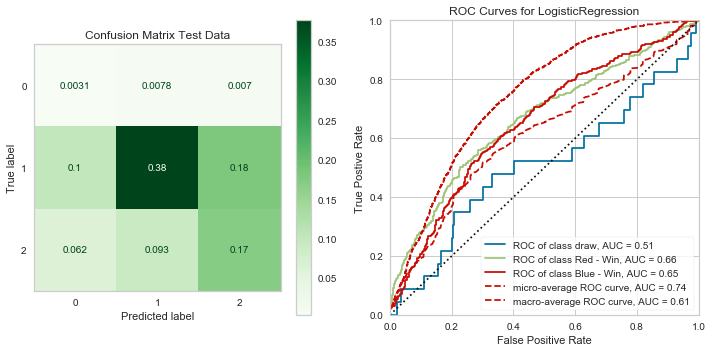

---- Timer stopped at: 04/27/2020 - 08:46 PM ----
---- Time elasped: 0:00:01.187388 ----


DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Classification Report Test
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.69      0.65      0.67       845
           2       0.37      0.40      0.38       418

    accuracy                           0.55      1286
   macro avg       0.35      0.35      0.35      1286
weighted avg       0.57      0.55      0.56      1286



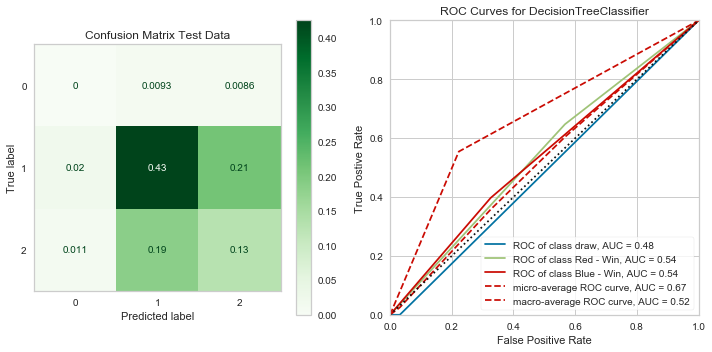

---- Timer stopped at: 04/27/2020 - 08:46 PM ----
---- Time elasped: 0:00:01.864052 ----


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Classification Report Test
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.72      0.79      0.76       845
           2       0.50      0.42      0.46       418

    accuracy                           0.66      1286
   macro avg       0.41      0.41      0.40      1286
weighted avg       0.64      0.66      0.64      1286



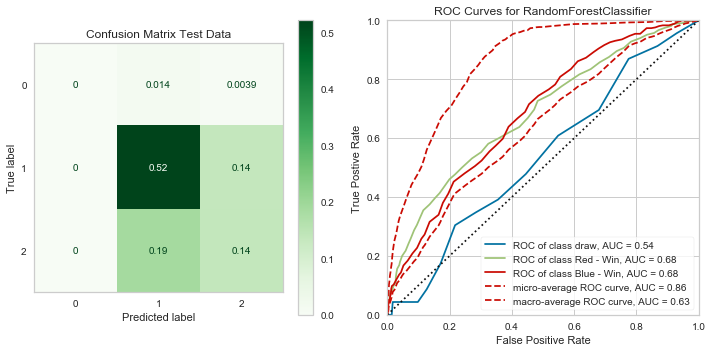

---- Timer stopped at: 04/27/2020 - 08:47 PM ----
---- Time elasped: 0:00:06.475685 ----


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

Classification Report Test
              precision    recall  f1-score   support

           0       0.01      0.04      0.01        23
           1       0.76      0.43      0.55       845
           2       0.39      0.65      0.48       418

    accuracy                           0.49      1286
   macro avg       0.38      0.37      0.35      1286
weighted avg       0.62      0.49      0.52      1286



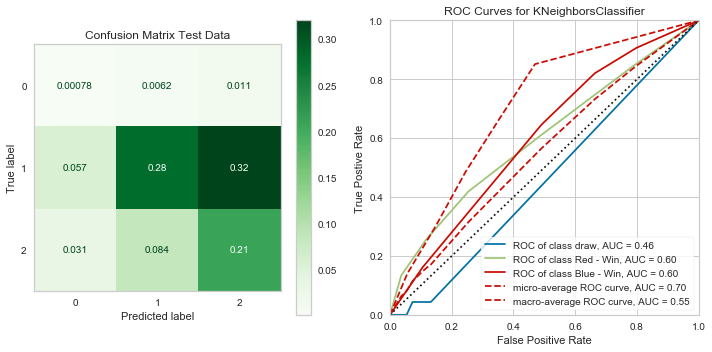

---- Timer stopped at: 04/27/2020 - 08:47 PM ----
---- Time elasped: 0:00:42.575127 ----


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

Classification Report Test
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.71      0.69      0.70       845
           2       0.42      0.45      0.43       418

    accuracy                           0.60      1286
   macro avg       0.38      0.38      0.38      1286
weighted avg       0.60      0.60      0.60      1286



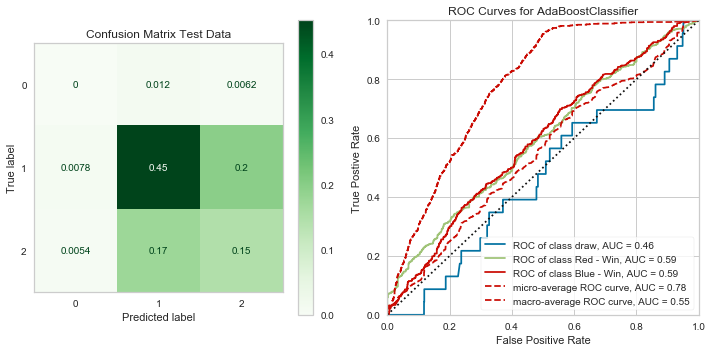

---- Timer stopped at: 04/27/2020 - 08:47 PM ----
---- Time elasped: 0:00:06.952451 ----


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

Classification Report Test
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.71      0.82      0.76       845
           2       0.48      0.35      0.40       418

    accuracy                           0.65      1286
   macro avg       0.39      0.39      0.39      1286
weighted avg       0.62      0.65      0.63      1286



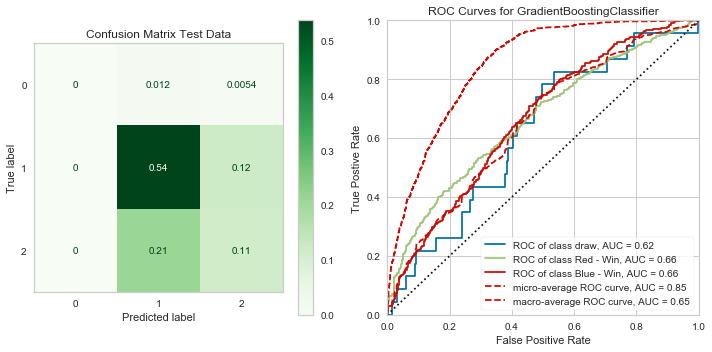

---- Timer stopped at: 04/27/2020 - 08:49 PM ----
---- Time elasped: 0:01:23.861824 ----


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, num_class=3, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

Classification Report Test
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.70      0.81      0.75       845
           2       0.47      0.35      0.40       418

    accuracy                           0.65      1286
   macro avg       0.39      0.39      0.39      1286
weighted avg       0.62      0.65      0.63      1286



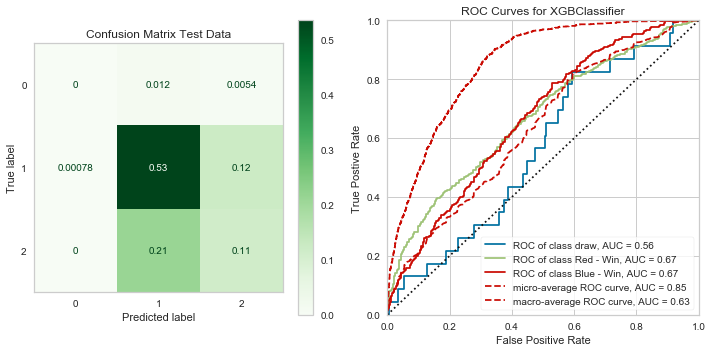

---- Timer stopped at: 04/27/2020 - 08:49 PM ----
---- Time elasped: 0:00:16.089930 ----


In [64]:
## Model check

mods = [log_clf, tree_clf, rf_clf, knn_clf, ada_clf, grad_clf, xgb_clf]
mod_labs = ['log_clf', 'tree_clf', 'rf_clf', 'knn_clf', 'ada_clf', 'grad_clf', 'xgb_clf']
t = dlf.Timer()
labs = ['draw', 'Red - Win', 'Blue - Win']

times = dlf.time_models(X_trn_sca_resmp, X_test_sca, y_trn_resmp, y_test, mods, mod_labs, t, cls_lab=labs)

In [65]:
times_sorted = sorted(times.items(), key=lambda x: x[1])
times_sorted

[('log_clf', 1.187388),
 ('tree_clf', 1.864052),
 ('rf_clf', 6.475685),
 ('ada_clf', 6.952451),
 ('xgb_clf', 16.08993),
 ('knn_clf', 42.575127),
 ('grad_clf', 83.861824)]

> Model decisions:
* __Keep__: XGB, RandForest 
* __Drop__: GradBoost, AdaBoost, KNN, DecisionTree, Logistic

> Why?:
* Either the time is too long to be worth the effort or the vanilla results netted an accuracy too close to random chance according to the accuracy and weighted/macro averages in the classifcation report. Given these two metrics, I have decided to keep on with the XGB and RandomForest classifiers for parameter tuning.

### Tuning Models

In [67]:
# To be tuned: max_depth (3), n_estimators (100), learning_rate (0.1)

xgb_clf = xgb.XGBClassifier(objective='multi:softprob', num_class=3)

xgb_params = {'max_depth': [2, 5],
              'n_estimators': [115, 130],
              'learning_rate': [0.05, 0.2]}

xgb_gridsrch = GridSearchCV(xgb_clf, xgb_params, cv=3, return_train_score=True)

t2 = dlf.Timer()

In [68]:
t2.start()
xgb_gridsrch.fit(X_trn_sca_resmp, y_trn_resmp)
t2.stop()

---- Timer stopped at: 04/27/2020 - 08:56 PM ----
---- Time elasped: 0:06:12.367633 ----


In [69]:
xgb_tr_score = np.mean(xgb_gridsrch.cv_results_['mean_train_score'])
xgb_te_score = xgb_gridsrch.score(X_test_sca, y_test)

print(f"Mean Training Score: {xgb_tr_score :.2%}")
print(f"Mean Test Score: {xgb_te_score :.2%}")
print("Best Parameter Combination Found During Grid Search:")
xgb_gridsrch.best_params_

Mean Training Score: 89.22%
Mean Test Score: 65.63%
Best Parameter Combination Found During Grid Search:


{'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 115}

In [71]:
# To be tuned: max_depth (None), n_estimators (100), max_features ('auto'), criterion ('gini') 

rf_clf = RandomForestClassifier(class_weight='balanced')

rf_params = {'criterion': ['gini', 'entropy'],
             'max_depth': [3, 7],
             'n_estimators': [115, 125],
             'max_features': [0.5, 0.8]}

rf_gridsrch = GridSearchCV(rf_clf, rf_params, cv=3, return_train_score=True)

t3 = dlf.Timer()

In [72]:
t3.start()
rf_gridsrch.fit(X_trn_sca_resmp, y_trn_resmp)
t3.stop()

---- Timer stopped at: 04/27/2020 - 09:15 PM ----
---- Time elasped: 0:15:35.718703 ----


In [73]:
rf_tr_score = np.mean(rf_gridsrch.cv_results_['mean_train_score'])
rf_te_score = rf_gridsrch.score(X_test_sca, y_test)

print(f"Mean Training Score: {rf_tr_score :.2%}")
print(f"Mean Test Score: {rf_te_score :.2%}")
print("Best Parameter Combination Found During Grid Search:")
rf_gridsrch.best_params_

Mean Training Score: 71.79%
Mean Test Score: 61.43%
Best Parameter Combination Found During Grid Search:


{'criterion': 'gini', 'max_depth': 7, 'max_features': 0.5, 'n_estimators': 125}

> Now I will be moving forward with the XGB Classifier for now, 4 points is enough for me to stick with this estimator, however, if I do want to revisit this problem I will check on the results of a random forest as well. I will try some more tuning of the same parameters to try and get higher than 66%, which was the same accuracy of the vanilla model.

In [74]:
#xgb_params2 = {'max_depth': [4, 7],
#              'n_estimators': [150, 175],
#              'learning_rate': [0.15, 0.25]}
#
#xgb_gridsrch2 = grid_searcher(xgb_clf, xgb_params2, X_trn_sca_resmp, X_test_sca,
#                              y_trn_resmp, y_test, cv=3)

In [75]:
#xgb_params3 = {'max_depth': [1, 2, 3],
#              'n_estimators': [90, 140],
#              'learning_rate': [0.125, 0.175]}
#
#xgb_gridsrch3 = grid_searcher(xgb_clf, xgb_params3, X_trn_sca_resmp, X_test_sca,
#                              y_trn_resmp, y_test, cv=3)

In [76]:
#xgb_params4 = {'max_depth': [3, 4],
#              'n_estimators': [100, 120],
#              'learning_rate': [0.15, 0.175]}
#
#xgb_gridsrch4 = grid_searcher(xgb_clf, xgb_params4, X_trn_sca_resmp, X_test_sca,
#                              y_trn_resmp, y_test, cv=3)

In [77]:
#xgb_params5 = {'max_depth': [4, 5],
#              'n_estimators': [120, 110],
#              'learning_rate': [0.1, 0.175, 0.2]}
#
#xgb_gridsrch5 = grid_searcher(xgb_clf, xgb_params5, X_trn_sca_resmp, X_test_sca,
#                              y_trn_resmp, y_test, cv=3)

In [78]:
#xgb_params6 = {'max_depth': [2],
#              'n_estimators': [90, 100],
#              'learning_rate': [0.05, 0.01]}
#
#xgb_gridsrch6 = grid_searcher(xgb_clf, xgb_params6, X_trn_sca_resmp, X_test_sca,
#                              y_trn_resmp, y_test, cv=3)

In [79]:
#xgb_params7 = {'max_depth': [1],
#              'n_estimators': [100, 110],
#              'learning_rate': [0.05, 0.1]}
#
#xgb_gridsrch7 = grid_searcher(xgb_clf, xgb_params7, X_trn_sca_resmp, X_test_sca,
#                              y_trn_resmp, y_test, cv=3)

In [81]:
xgb_params8 = {'max_depth': [1],
              'n_estimators': [200],
              'learning_rate': [0.05, 0.1]}

xgb_gridsrch8 = dlf.grid_searcher(xgb_clf, xgb_params8, X_trn_sca_resmp, X_test_sca,
                              y_trn_resmp, y_test, cv=3)

---- Timer stopped at: 04/27/2020 - 09:17 PM ----
---- Time elasped: 0:00:53.056722 ----
Mean Training Score: 70.03%
Mean Test Score: 59.49%
Best Parameters:
{'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 200}


In [82]:
xgb_params9 = {'max_depth': [2],
              'n_estimators': [50],
              'learning_rate': [0.2]}

xgb_gridsrch9 = dlf.grid_searcher(xgb_clf, xgb_params9, X_trn_sca_resmp, X_test_sca,
                              y_trn_resmp, y_test, cv=3)

---- Timer stopped at: 04/27/2020 - 09:18 PM ----
---- Time elasped: 0:00:13.313452 ----
Mean Training Score: 81.26%
Mean Test Score: 64.93%
Best Parameters:
{'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 50}


### Creating Final-*ish* Model

> I will go with the closest of the two scores to stay away from models that are overfit. These are:

* max_depth: 2
* learning_rate: 0.05
* n_estimators: 50

In [83]:
xgb_fin = xgb.XGBClassifier(max_depth=2, learning_rate=0.05, n_estimators=50, 
                            objective='multi:softprob', num_class=3)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
              max_depth=2, min_child_weight=1, missing=None, n_estimators=50,
              n_jobs=1, nthread=None, num_class=3, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

Classification Report Test
              precision    recall  f1-score   support

           0       0.02      0.09      0.04        23
           1       0.72      0.71      0.71       845
           2       0.46      0.41      0.44       418

    accuracy                           0.60      1286
   macro avg       0.40      0.40      0.40      1286
weighted avg       0.63      0.60      0.61      1286



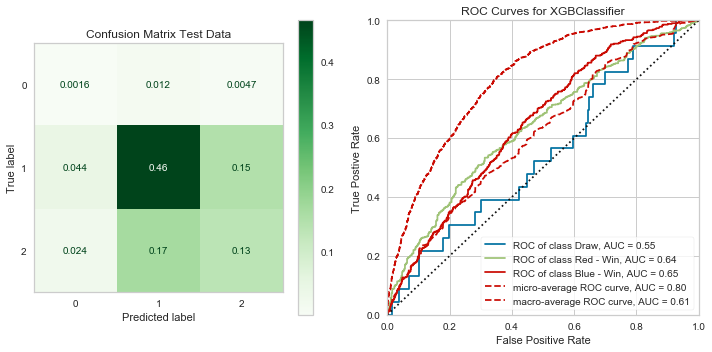

---- Timer stopped at: 04/27/2020 - 09:18 PM ----
---- Time elasped: 0:00:05.664888 ----


In [84]:
t_fin = dlf.Timer()
labs = ['Draw', 'Red - Win', 'Blue - Win']

time_fin = dlf.time_models(X_trn_sca_resmp, X_test_sca, y_trn_resmp, y_test, [xgb_fin], ['XGB Final'], t_fin, cls_lab=labs)

> Not *entirely* what I expected. But it is clear that my model is failing to predict class 0 (Draw outcome). I am going to try my hand at a binary classification.

### Re-evaluation of data

In [85]:
## Starting over and resetting target to only include fights with a winner

dummy_binary = pd.get_dummies(cat_df)
dummy_binary.drop(columns=['title_bout', 'Winner_Red'], inplace=True)

draws = dummy_binary[dummy_binary['Winner_Draw'] == 1].index
dummy_binary.drop(columns='Winner_Draw', index=draws, inplace=True)

dummy_binary.head()

,Winner_Blue,weight_class_Bantamweight,weight_class_Catch Weight,weight_class_Featherweight,weight_class_Flyweight,weight_class_Heavyweight,weight_class_Light Heavyweight,weight_class_Lightweight,weight_class_Middleweight,weight_class_Open Weight,...,B_Stance_Open Stance,B_Stance_Orthodox,B_Stance_Sideways,B_Stance_Southpaw,B_Stance_Switch,R_Stance_Open Stance,R_Stance_Orthodox,R_Stance_Sideways,R_Stance_Southpaw,R_Stance_Switch
0,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
4,1,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [86]:
## Putting it all together again

df_full_binary = pd.concat([df_fill.drop(columns=drop_cols), win_series, title_series], axis=1).copy()

In [87]:
df_full_binary.drop(index=draws, inplace=True)
df_full_binary = pd.concat([df_full_binary, dummy_binary], axis=1)
#df_full_binary.head()

#### Re-prep for model

In [88]:
## Train-test split

y_bin = df_full_binary['Winner_Blue'].copy()
X_bin = df_full_binary.drop(['Winner_Blue', 'Winner'], axis=1).copy()

X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X_bin, y_bin)

In [89]:
print('Original Class Balance')
display(y_bin.value_counts(normalize=True))
print('y_train Class Balance')
display(y_train_bin.value_counts(normalize=True))
print('y_test Class Balance')
display(y_test_bin.value_counts(normalize=True))

Original Class Balance


0    0.685635
1    0.314365
Name: Winner_Blue, dtype: float64

y_train Class Balance


0    0.690382
1    0.309618
Name: Winner_Blue, dtype: float64

y_test Class Balance


0    0.671406
1    0.328594
Name: Winner_Blue, dtype: float64

In [90]:
## Min max scale to help with varying values

scaler_bin = MinMaxScaler()

X_train_sca_bin = pd.DataFrame(scaler.fit_transform(X_train_bin), columns=X_train_bin.columns,
                           index=X_train_bin.index)
X_test_sca_bin = pd.DataFrame(scaler.transform(X_test_bin), columns=X_test_bin.columns, 
                          index=X_test_bin.index)

In [91]:
## Fix class imbalance

print('Original class distribution: \n')
print(y_train_bin.value_counts())

smote_bin = SMOTE()
X_trn_sca_resmp_bin, y_trn_resmp_bin = smote_bin.fit_sample(X_train_sca_bin, y_train_bin)
X_trn_sca_resmp_bin = pd.DataFrame(X_trn_sca_resmp_bin, columns=X_train_sca_bin.columns)

## Preview resampled class distribution
print('-----------------------------------------')
print('Resampled class distribution: \n')
print(pd.Series(y_trn_resmp_bin).value_counts()) 

Original class distribution: 

0    2620
1    1175
Name: Winner_Blue, dtype: int64
-----------------------------------------
Resampled class distribution: 

1    2620
0    2620
dtype: int64


#### Vanilla Check

In [92]:
tree_clf_bin = DecisionTreeClassifier(class_weight='balanced')
rf_clf_bin = RandomForestClassifier(class_weight='balanced')
log_clf_bin = LogisticRegression(C=1e9, class_weight='balanced', solver='liblinear')
knn_clf_bin = KNeighborsClassifier()
ada_clf_bin = AdaBoostClassifier()
grad_clf_bin = GradientBoostingClassifier()
xgb_clf_bin = xgb.XGBClassifier()

LogisticRegression(C=1000000000.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Classification Report Test
              precision    recall  f1-score   support

           0       0.81      0.69      0.74       850
           1       0.51      0.66      0.58       416

    accuracy                           0.68      1266
   macro avg       0.66      0.68      0.66      1266
weighted avg       0.71      0.68      0.69      1266



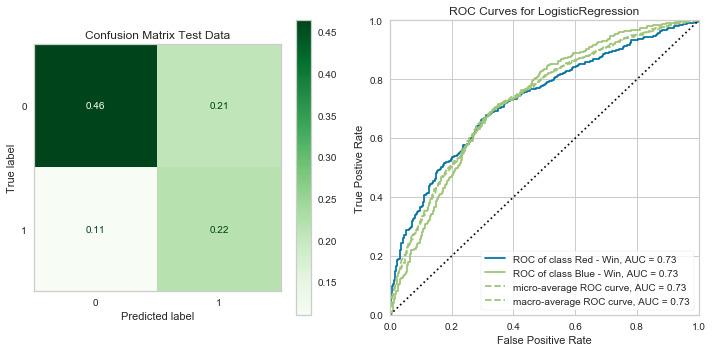

---- Timer stopped at: 04/27/2020 - 09:24 PM ----
---- Time elasped: 0:00:01.476020 ----


DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Classification Report Test
              precision    recall  f1-score   support

           0       0.71      0.70      0.70       850
           1       0.41      0.42      0.41       416

    accuracy                           0.61      1266
   macro avg       0.56      0.56      0.56      1266
weighted avg       0.61      0.61      0.61      1266



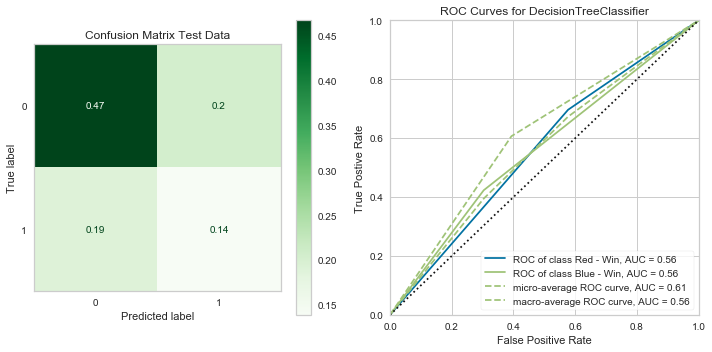

---- Timer stopped at: 04/27/2020 - 09:24 PM ----
---- Time elasped: 0:00:01.048227 ----


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Classification Report Test
              precision    recall  f1-score   support

           0       0.68      0.93      0.78       850
           1       0.42      0.11      0.17       416

    accuracy                           0.66      1266
   macro avg       0.55      0.52      0.48      1266
weighted avg       0.59      0.66      0.58      1266



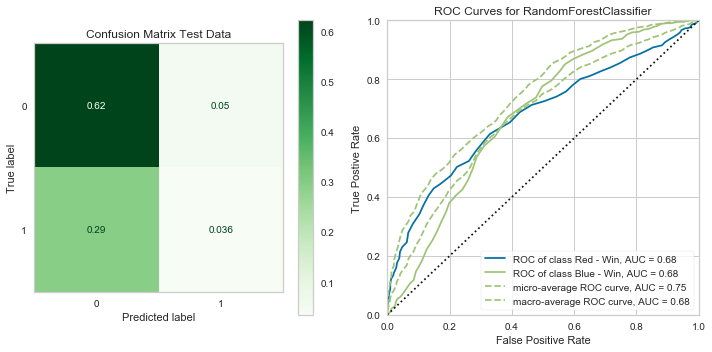

---- Timer stopped at: 04/27/2020 - 09:24 PM ----
---- Time elasped: 0:00:03.333059 ----


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

Classification Report Test
              precision    recall  f1-score   support

           0       0.70      0.78      0.74       850
           1       0.41      0.32      0.36       416

    accuracy                           0.63      1266
   macro avg       0.56      0.55      0.55      1266
weighted avg       0.60      0.63      0.61      1266



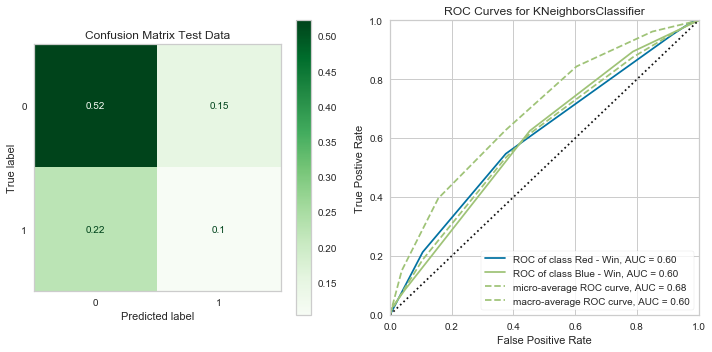

---- Timer stopped at: 04/27/2020 - 09:24 PM ----
---- Time elasped: 0:00:12.550474 ----


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

Classification Report Test
              precision    recall  f1-score   support

           0       0.72      0.88      0.79       850
           1       0.54      0.30      0.38       416

    accuracy                           0.69      1266
   macro avg       0.63      0.59      0.59      1266
weighted avg       0.66      0.69      0.66      1266



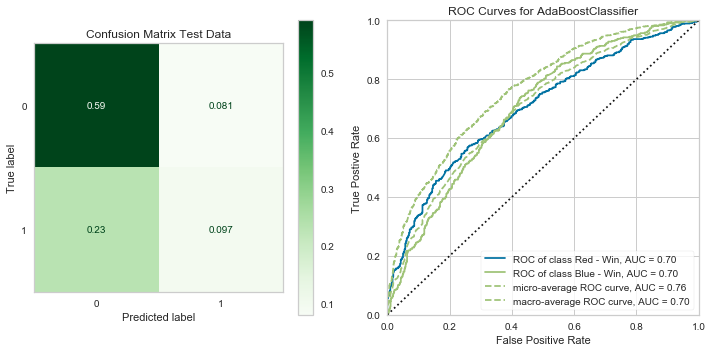

---- Timer stopped at: 04/27/2020 - 09:24 PM ----
---- Time elasped: 0:00:02.401591 ----


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

Classification Report Test
              precision    recall  f1-score   support

           0       0.71      0.91      0.80       850
           1       0.57      0.24      0.33       416

    accuracy                           0.69      1266
   macro avg       0.64      0.57      0.57      1266
weighted avg       0.66      0.69      0.65      1266



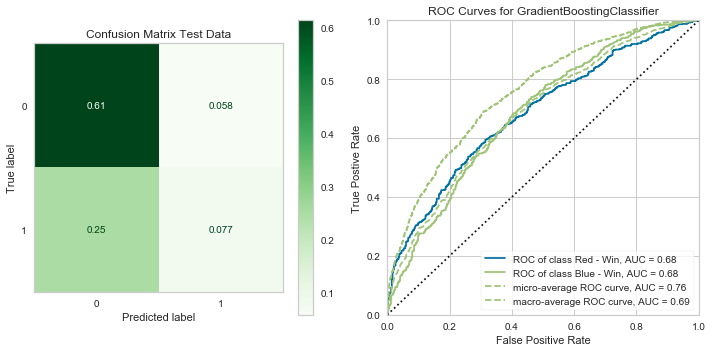

---- Timer stopped at: 04/27/2020 - 09:24 PM ----
---- Time elasped: 0:00:07.875940 ----


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

Classification Report Test
              precision    recall  f1-score   support

           0       0.71      0.91      0.80       850
           1       0.56      0.23      0.32       416

    accuracy                           0.69      1266
   macro avg       0.63      0.57      0.56      1266
weighted avg       0.66      0.69      0.64      1266



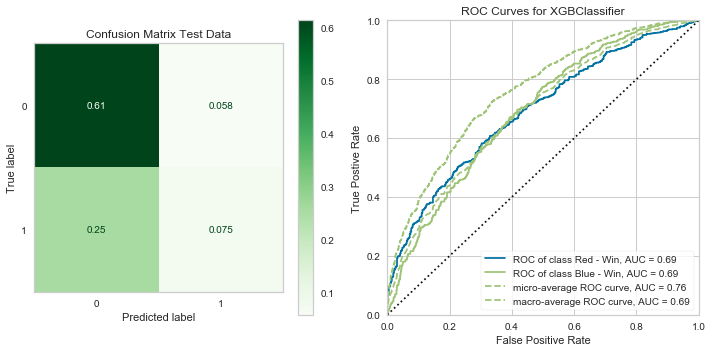

---- Timer stopped at: 04/27/2020 - 09:24 PM ----
---- Time elasped: 0:00:02.666879 ----


In [93]:
mods_bin = [log_clf_bin, tree_clf_bin, rf_clf_bin, knn_clf_bin, ada_clf_bin, grad_clf_bin, xgb_clf_bin]
mod_labs_bin = ['log_clf_bin', 'tree_clf_bin', 'rf_clf_bin', 'knn_clf_bin', 'ada_clf_bin', 'grad_clf_bin', 'xgb_clf_bin']
t_bin = dlf.Timer()
labs_bin = ['Red - Win', 'Blue - Win']

times_bin = dlf.time_models(X_train_sca_bin, X_test_sca_bin, y_train_bin, y_test_bin, mods_bin, mod_labs_bin, t_bin, cls_lab=labs_bin)

> Pretty similar results to the multi-class models, hopefully running some grid searches will help.

#### Re-tune

In [94]:
## For reference

#rf_clf_bin = RandomForestClassifier(class_weight='balanced')
#tree_clf_bin = DecisionTreeClassifier(class_weight='balanced')

In [97]:
tree_params_bin = {'criterion': ['gini', 'entropy'],
                 'min_samples_leaf': [3],
                 'max_depth': [10],
                 'max_features': [0.8, 0.5]}

tree_gridsrch_bin = dlf.grid_searcher(tree_clf_bin, tree_params_bin, X_trn_sca_resmp_bin,
                                 X_test_sca_bin, y_trn_resmp_bin, y_test_bin, cv=3)

---- Timer stopped at: 04/27/2020 - 09:27 PM ----
---- Time elasped: 0:00:03.375974 ----
Mean Training Score: 85.28%
Mean Test Score: 60.43%
Best Parameters:
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 0.8, 'min_samples_leaf': 3}


In [98]:
log_params_bin = {'C': [1e12, 1e5, 1e2, 1],
                  'solver': ['liblinear', 'saga']}

log_gridsrch_bin = dlf.grid_searcher(log_clf_bin, log_params_bin, X_trn_sca_resmp_bin,
                                 X_test_sca_bin, y_trn_resmp_bin, y_test_bin, cv=3)

---- Timer stopped at: 04/27/2020 - 09:28 PM ----
---- Time elasped: 0:00:16.271521 ----
Mean Training Score: 70.18%
Mean Test Score: 67.69%
Best Parameters:
{'C': 100.0, 'solver': 'liblinear'}


In [99]:
log_params_bin2 = {'C': [1],
                  'solver': ['liblinear']}

log_gridsrch_bin2 = dlf.grid_searcher(log_clf_bin, log_params_bin2, X_trn_sca_resmp_bin,
                                 X_test_sca_bin, y_trn_resmp_bin, y_test_bin, cv=3)

---- Timer stopped at: 04/27/2020 - 09:28 PM ----
---- Time elasped: 0:00:00.531575 ----
Mean Training Score: 69.73%
Mean Test Score: 66.19%
Best Parameters:
{'C': 1, 'solver': 'liblinear'}


LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Classification Report Test
              precision    recall  f1-score   support

           0       0.79      0.68      0.73       850
           1       0.49      0.63      0.55       416

    accuracy                           0.66      1266
   macro avg       0.64      0.66      0.64      1266
weighted avg       0.69      0.66      0.67      1266



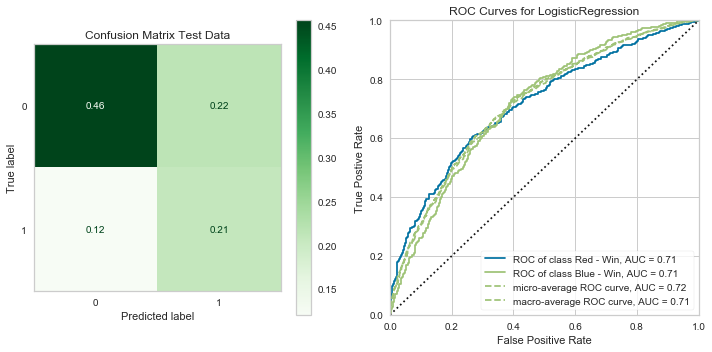

---- Timer stopped at: 04/27/2020 - 09:29 PM ----
---- Time elasped: 0:00:00.712094 ----


In [101]:
log_clf_bin_fin = LogisticRegression(C=1, class_weight='balanced', solver='liblinear')

mods_bin_fin = [log_clf_bin_fin]
mod_labs_bin_fin = ['log_clf_bin_fin']
t_bin_fin = dlf.Timer()

times_bin_fin = dlf.time_models(X_train_sca_bin, X_test_sca_bin, y_train_bin, y_test_bin, mods_bin_fin, mod_labs_bin_fin, t_bin_fin, cls_lab=labs_bin)

> By using the logistic regression model and re-formatting the problem I was able to get an overall accuracy of 66%. Although not much better, I prefer this one due to the number of true positives it was able to generate comparatively.

### Re-evaluation 2.0

> My thoughts now are that maybe the use of fighters without a history could be holding my model back, because it is making a guess about something without a value in many of the possible attributes.

#### Filling NAs

In [102]:
print(df.shape)
print(df_full_binary.shape)

(5144, 140)
(5061, 162)


> Here I dropped all of those avgs I filled previously

In [103]:
## Create a copy of the master and drop all of the rows with non-experienced
## fighters

df_fill_bin = df.copy()
df_fill_bin.dropna(subset=zero_fill_cols, inplace=True)

Stance Distributions:
Orthodox       0.763011
Southpaw       0.202574
Switch         0.032457
Open Stance    0.001399
Sideways       0.000560
Name: B_Stance, dtype: float64 

Orthodox       0.754479
Southpaw       0.214166
Switch         0.027996
Open Stance    0.003359
Name: R_Stance, dtype: float64

Stances:
['Orthodox', 'Switch', 'Southpaw', 'Open Stance', 'Sideways'] 

Stance Probabilities:
[7.63010632e-01 2.02574147e-01 3.24566312e-02 1.39899273e-03
 5.59597090e-04] 

Null Values Remaining:


4800   NaN
4814   NaN
Name: R_Reach_cms, dtype: float64

4800   NaN
4814   NaN
Name: B_Reach_cms, dtype: float64

Age Mean:
B_age    29.649220
R_age    29.940319
dtype: float64 

Midpoint Age Mean:
29.79476976094046


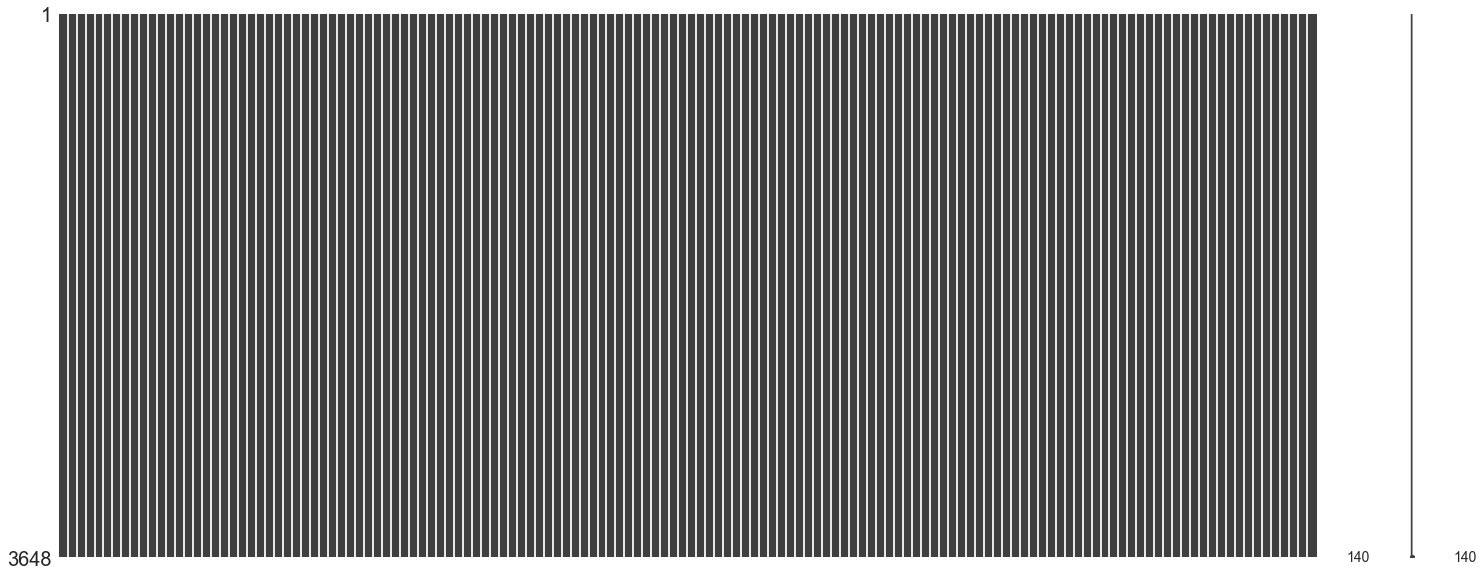

In [107]:
## Quick helper to minimize code length

df_fill_bin = dlf.NA_handler_bin(df_fill_bin);

#### Endcoding Categoricals

In [109]:
cat_df_bin_skim = df_fill_bin.select_dtypes(['object', 'bool']).copy()

dummy_binary_skim = pd.get_dummies(cat_df_bin_skim)
dummy_binary_skim.drop(columns=['title_bout', 'Winner_Red'], inplace=True)

draws_skim = dummy_binary_skim[dummy_binary_skim['Winner_Draw'] == 1].index
dummy_binary_skim.drop(columns='Winner_Draw', index=draws_skim, inplace=True)
print('Dummy Df columns:')
print(dummy_binary_skim.columns, '\n')

title_series_skim = cat_df_bin_skim['title_bout'].copy()
title_series_skim = title_series_skim.map(dict_title)
print('Title Bout Values:')
display(title_series_skim.head())

Dummy Df columns:
Index(['Winner_Blue', 'weight_class_Bantamweight', 'weight_class_Catch Weight',
       'weight_class_Featherweight', 'weight_class_Flyweight',
       'weight_class_Heavyweight', 'weight_class_Light Heavyweight',
       'weight_class_Lightweight', 'weight_class_Middleweight',
       'weight_class_Open Weight', 'weight_class_Welterweight',
       'weight_class_Women's Bantamweight',
       'weight_class_Women's Featherweight', 'weight_class_Women's Flyweight',
       'weight_class_Women's Strawweight', 'B_Stance_Open Stance',
       'B_Stance_Orthodox', 'B_Stance_Sideways', 'B_Stance_Southpaw',
       'B_Stance_Switch', 'R_Stance_Open Stance', 'R_Stance_Orthodox',
       'R_Stance_Southpaw', 'R_Stance_Switch'],
      dtype='object') 

Title Bout Values:


0    1
1    1
2    0
3    0
4    0
Name: title_bout, dtype: int64

In [110]:
df_skim_binary = pd.concat([df_fill_bin.drop(columns=drop_cols), title_series_skim], axis=1).copy()

In [111]:
df_skim_binary.drop(index=draws_skim, inplace=True)
df_skim_binary = pd.concat([df_skim_binary, dummy_binary_skim], axis=1)
print(df_skim_binary.shape)
df_skim_binary.head()

(3592, 160)


,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_BODY_att,B_avg_BODY_landed,B_avg_CLINCH_att,B_avg_CLINCH_landed,B_avg_DISTANCE_att,B_avg_DISTANCE_landed,...,weight_class_Women's Strawweight,B_Stance_Open Stance,B_Stance_Orthodox,B_Stance_Sideways,B_Stance_Southpaw,B_Stance_Switch,R_Stance_Open Stance,R_Stance_Orthodox,R_Stance_Southpaw,R_Stance_Switch
0,5,0.0,4.0,0.0,9.200000,6.000000,0.200000,0.000000,62.600000,20.600000,...,0,0,1,0,0,0,0,1,0,0
1,5,0.0,3.0,0.0,14.600000,9.100000,11.800000,7.300000,124.700000,42.100000,...,0,0,1,0,0,0,0,0,1,0
2,3,0.0,3.0,0.0,15.354839,11.322581,6.741935,4.387097,84.741935,38.580645,...,0,0,1,0,0,0,0,1,0,0
3,3,0.0,4.0,0.0,17.000000,14.000000,13.750000,11.000000,109.500000,48.750000,...,0,0,0,0,0,1,0,1,0,0
4,3,0.0,1.0,0.0,17.000000,14.500000,2.500000,2.000000,201.000000,59.500000,...,0,0,0,0,1,0,0,0,1,0


#### Re-prep 2.0

In [112]:
y_bin_skim = df_skim_binary['Winner_Blue'].copy()
X_bin_skim = df_skim_binary.drop(['Winner_Blue'], axis=1).copy()

X_train_bin_skim, X_test_bin_skim, y_train_bin_skim, y_test_bin_skim = train_test_split(X_bin_skim, y_bin_skim, test_size=0.2)

In [113]:
X_bin_skim.columns

Index(['no_of_rounds', 'B_current_lose_streak', 'B_current_win_streak',
       'B_draw', 'B_avg_BODY_att', 'B_avg_BODY_landed', 'B_avg_CLINCH_att',
       'B_avg_CLINCH_landed', 'B_avg_DISTANCE_att', 'B_avg_DISTANCE_landed',
       ...
       'weight_class_Women's Strawweight', 'B_Stance_Open Stance',
       'B_Stance_Orthodox', 'B_Stance_Sideways', 'B_Stance_Southpaw',
       'B_Stance_Switch', 'R_Stance_Open Stance', 'R_Stance_Orthodox',
       'R_Stance_Southpaw', 'R_Stance_Switch'],
      dtype='object', length=159)

In [114]:
print('Original Class Balance')
display(y_bin_skim.value_counts(normalize=True))
print('y_train Class Balance')
display(y_train_bin_skim.value_counts(normalize=True))
print('y_test Class Balance')
display(y_test_bin_skim.value_counts(normalize=True))

Original Class Balance


0    0.662584
1    0.337416
Name: Winner_Blue, dtype: float64

y_train Class Balance


0    0.669335
1    0.330665
Name: Winner_Blue, dtype: float64

y_test Class Balance


0    0.635605
1    0.364395
Name: Winner_Blue, dtype: float64

In [115]:
scaler_bin_skim = MinMaxScaler()

X_train_sca_bin_skim = pd.DataFrame(scaler.fit_transform(X_train_bin_skim), columns=X_train_bin_skim.columns,
                           index=X_train_bin_skim.index)
X_test_sca_bin_skim = pd.DataFrame(scaler.transform(X_test_bin_skim), columns=X_test_bin_skim.columns, 
                          index=X_test_bin_skim.index)

In [116]:
print('Original class distribution: \n')
print(y_train_bin_skim.value_counts())

smote_bin_skim = SMOTE()
X_trn_sca_resmp_bin_skim, y_trn_resmp_bin_skim = smote_bin_skim.fit_sample(X_train_sca_bin_skim, y_train_bin_skim)
X_trn_sca_resmp_bin_skim = pd.DataFrame(X_trn_sca_resmp_bin_skim, columns=X_train_sca_bin_skim.columns)

# Preview synthetic sample class distribution
print('-----------------------------------------')
print('Resampled class distribution: \n')
print(pd.Series(y_trn_resmp_bin_skim).value_counts()) 

Original class distribution: 

0    1923
1     950
Name: Winner_Blue, dtype: int64
-----------------------------------------
Resampled class distribution: 

1    1923
0    1923
dtype: int64


#### Vanilla Check 2.0

In [117]:
tree_clf_bin2 = DecisionTreeClassifier(class_weight='balanced')
rf_clf_bin2 = RandomForestClassifier(class_weight='balanced')
log_clf_bin2 = LogisticRegression(class_weight='balanced', solver='liblinear')
knn_clf_bin2 = KNeighborsClassifier()
ada_clf_bin2 = AdaBoostClassifier()
grad_clf_bin2 = GradientBoostingClassifier()
xgb_clf_bin2 = xgb.XGBClassifier()

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Classification Report Test
              precision    recall  f1-score   support

           0       0.75      0.62      0.68       457
           1       0.49      0.64      0.55       262

    accuracy                           0.63       719
   macro avg       0.62      0.63      0.62       719
weighted avg       0.66      0.63      0.63       719



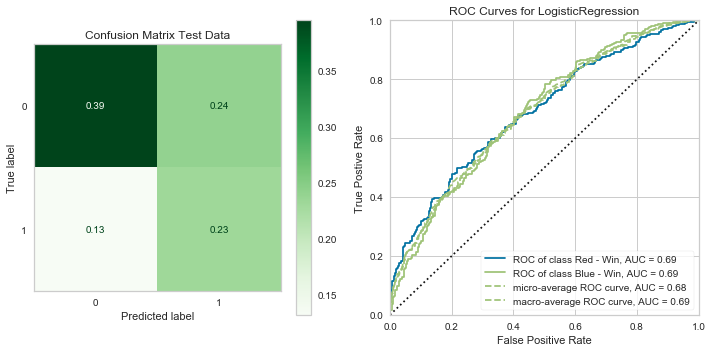

---- Timer stopped at: 04/27/2020 - 09:47 PM ----
---- Time elasped: 0:00:00.705115 ----


DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Classification Report Test
              precision    recall  f1-score   support

           0       0.67      0.68      0.68       457
           1       0.43      0.42      0.43       262

    accuracy                           0.59       719
   macro avg       0.55      0.55      0.55       719
weighted avg       0.58      0.59      0.58       719



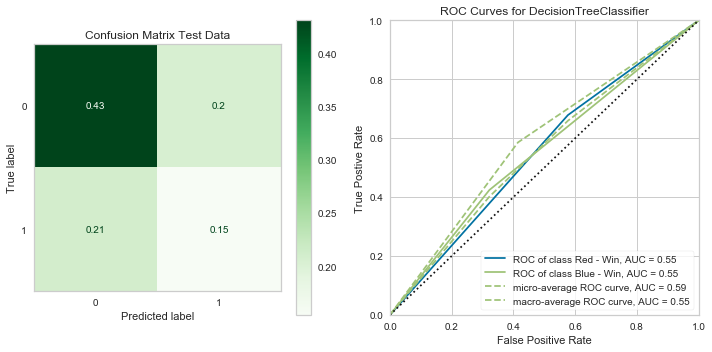

---- Timer stopped at: 04/27/2020 - 09:47 PM ----
---- Time elasped: 0:00:00.896603 ----


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Classification Report Test
              precision    recall  f1-score   support

           0       0.66      0.92      0.77       457
           1       0.53      0.15      0.24       262

    accuracy                           0.64       719
   macro avg       0.59      0.54      0.50       719
weighted avg       0.61      0.64      0.57       719



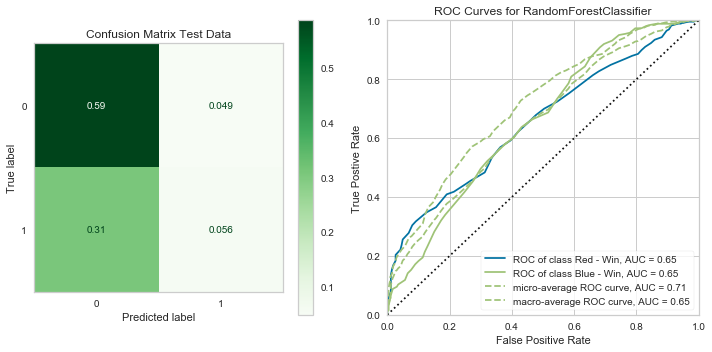

---- Timer stopped at: 04/27/2020 - 09:47 PM ----
---- Time elasped: 0:00:02.875342 ----


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

Classification Report Test
              precision    recall  f1-score   support

           0       0.67      0.81      0.73       457
           1       0.48      0.31      0.38       262

    accuracy                           0.62       719
   macro avg       0.57      0.56      0.55       719
weighted avg       0.60      0.62      0.60       719



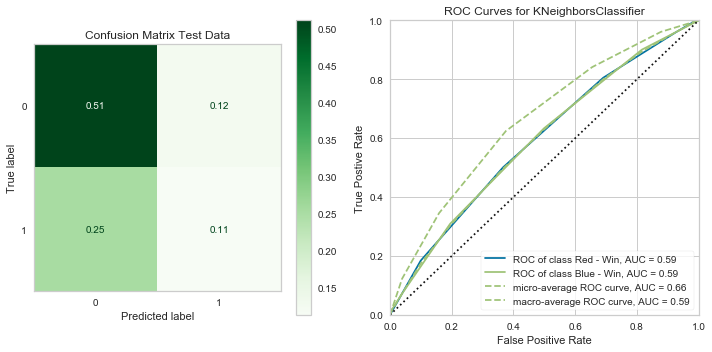

---- Timer stopped at: 04/27/2020 - 09:47 PM ----
---- Time elasped: 0:00:07.565786 ----


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

Classification Report Test
              precision    recall  f1-score   support

           0       0.68      0.81      0.74       457
           1       0.51      0.35      0.41       262

    accuracy                           0.64       719
   macro avg       0.60      0.58      0.58       719
weighted avg       0.62      0.64      0.62       719



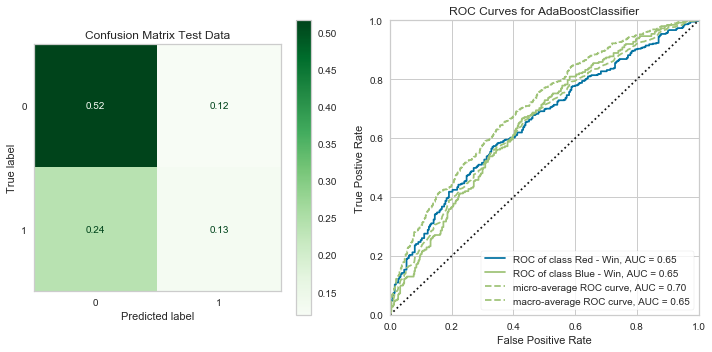

---- Timer stopped at: 04/27/2020 - 09:47 PM ----
---- Time elasped: 0:00:02.303829 ----


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

Classification Report Test
              precision    recall  f1-score   support

           0       0.67      0.89      0.77       457
           1       0.56      0.24      0.34       262

    accuracy                           0.65       719
   macro avg       0.61      0.57      0.55       719
weighted avg       0.63      0.65      0.61       719



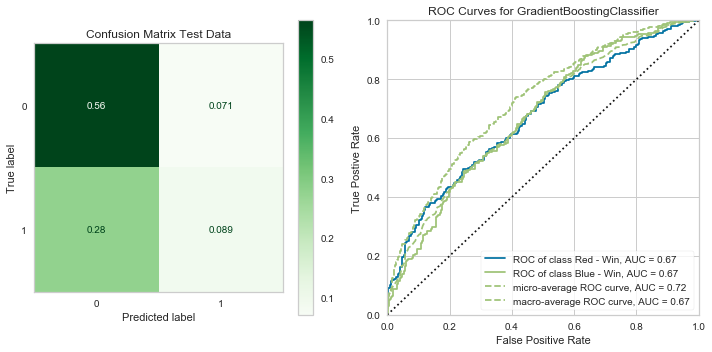

---- Timer stopped at: 04/27/2020 - 09:47 PM ----
---- Time elasped: 0:00:07.590721 ----


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

Classification Report Test
              precision    recall  f1-score   support

           0       0.68      0.88      0.76       457
           1       0.55      0.27      0.36       262

    accuracy                           0.66       719
   macro avg       0.62      0.57      0.56       719
weighted avg       0.63      0.66      0.62       719



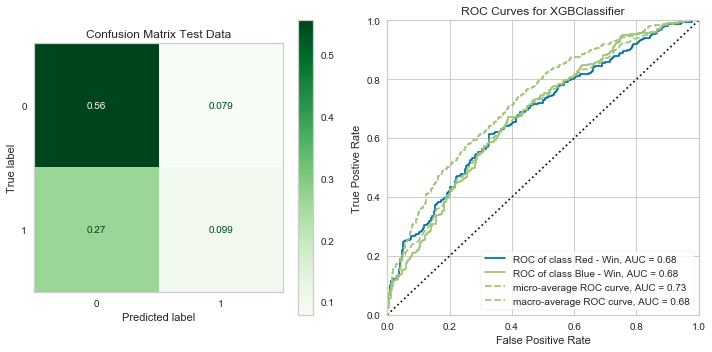

---- Timer stopped at: 04/27/2020 - 09:47 PM ----
---- Time elasped: 0:00:02.228032 ----


In [118]:
mods_bin2 = [log_clf_bin2, tree_clf_bin2, rf_clf_bin2, knn_clf_bin2, ada_clf_bin2, grad_clf_bin2, xgb_clf_bin2]
mod_labs_bin2 = ['log_clf_bin2', 'tree_clf_bin2', 'rf_clf_bin2', 'knn_clf_bin2', 'ada_clf_bin2', 'grad_clf_bin2', 'xgb_clf_bin2']
t_bin2 = dlf.Timer()
labs_bin = ['Red - Win', 'Blue - Win']

times_bin2 = dlf.time_models(X_train_sca_bin_skim, X_test_sca_bin_skim, y_train_bin_skim, y_test_bin_skim, mods_bin2, mod_labs_bin2, t_bin2, cls_lab=labs_bin)

#### Re-tune 2.0

In [119]:
#ada_clf_bin2 = AdaBoostClassifier()
#log_clf_bin2 = LogisticRegression(class_weight='balanced', solver='liblinear')

In [121]:
log_params_bin_skim = {'C': [0.5, 1e10, 1e5],
                  'solver': ['liblinear', 'saga']}

log_gridsrch_bin_skim = dlf.grid_searcher(log_clf_bin2, log_params_bin_skim, X_trn_sca_resmp_bin_skim,
                                 X_test_sca_bin_skim, y_trn_resmp_bin_skim, y_test_bin_skim, cv=3)

---- Timer stopped at: 04/27/2020 - 09:49 PM ----
---- Time elasped: 0:00:13.517857 ----
Mean Training Score: 70.41%
Mean Test Score: 60.92%
Best Parameters:
{'C': 10000000000.0, 'solver': 'liblinear'}


In [122]:
log_params_bin_skim2 = {'C': [10],
                  'solver': ['liblinear', 'saga']}

log_gridsrch_bin_skim2 = dlf.grid_searcher(log_clf_bin2, log_params_bin_skim2, X_trn_sca_resmp_bin_skim,
                                 X_test_sca_bin_skim, y_trn_resmp_bin_skim, y_test_bin_skim, cv=3)

---- Timer stopped at: 04/27/2020 - 09:49 PM ----
---- Time elasped: 0:00:02.659925 ----
Mean Training Score: 70.57%
Mean Test Score: 60.92%
Best Parameters:
{'C': 10, 'solver': 'liblinear'}


In [123]:
ada_params_bin_skim = {'n_estimators': [100],
                       'learning_rate': [0.1, 0.175],
                       'base_estimator': [LogisticRegression(C=10, solver='saga')]}

ada_gridsrch_bin_skim = dlf.grid_searcher(ada_clf_bin2, ada_params_bin_skim, X_trn_sca_resmp_bin_skim,
                                 X_test_sca_bin_skim, y_trn_resmp_bin_skim, y_test_bin_skim, cv=3)

---- Timer stopped at: 04/27/2020 - 09:56 PM ----
---- Time elasped: 0:06:59.069704 ----
Mean Training Score: 64.85%
Mean Test Score: 62.87%
Best Parameters:
{'base_estimator': LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False), 'learning_rate': 0.175, 'n_estimators': 100}


In [124]:
ada_params_bin_skim2 = {'n_estimators': [1000],
                       'learning_rate': [0.175],
                       'base_estimator': [LogisticRegression(C=100000, solver='liblinear')]}

ada_gridsrch_bin_skim2 = dlf.grid_searcher(ada_clf_bin2, ada_params_bin_skim2, X_trn_sca_resmp_bin_skim,
                                 X_test_sca_bin_skim, y_trn_resmp_bin_skim, y_test_bin_skim, cv=3)

---- Timer stopped at: 04/27/2020 - 10:04 PM ----
---- Time elasped: 0:07:24.547366 ----
Mean Training Score: 70.58%
Mean Test Score: 60.36%
Best Parameters:
{'base_estimator': LogisticRegression(C=100000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False), 'learning_rate': 0.175, 'n_estimators': 1000}


In [125]:
log_skim1 = log_gridsrch_bin_skim.best_estimator_
log_skim2 = log_gridsrch_bin_skim2.best_estimator_
ada_skim = ada_gridsrch_bin_skim2.best_estimator_

LogisticRegression(C=10000000000.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Classification Report Test
              precision    recall  f1-score   support

           0       0.73      0.61      0.66       457
           1       0.47      0.61      0.53       262

    accuracy                           0.61       719
   macro avg       0.60      0.61      0.60       719
weighted avg       0.64      0.61      0.62       719



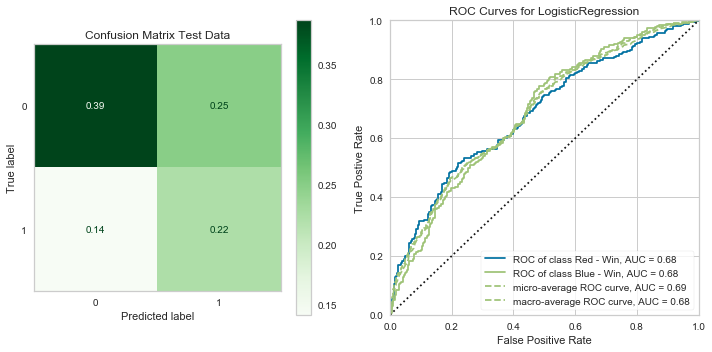

---- Timer stopped at: 04/27/2020 - 10:05 PM ----
---- Time elasped: 0:00:02.478348 ----


LogisticRegression(C=10, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Classification Report Test
              precision    recall  f1-score   support

           0       0.73      0.61      0.67       457
           1       0.47      0.60      0.53       262

    accuracy                           0.61       719
   macro avg       0.60      0.61      0.60       719
weighted avg       0.64      0.61      0.62       719



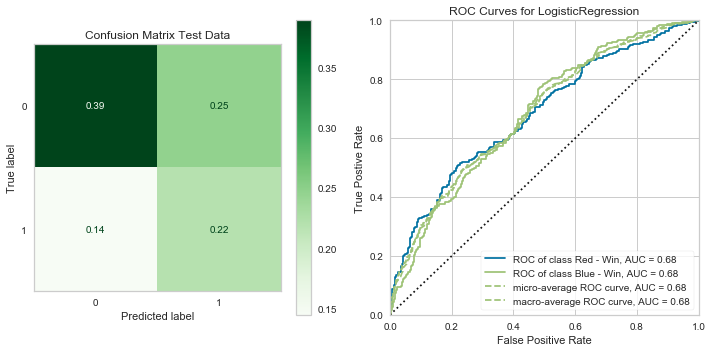

---- Timer stopped at: 04/27/2020 - 10:05 PM ----
---- Time elasped: 0:00:00.954477 ----


AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=LogisticRegression(C=100000,
                                                     class_weight=None,
                                                     dual=False,
                                                     fit_intercept=True,
                                                     intercept_scaling=1,
                                                     l1_ratio=None,
                                                     max_iter=100,
                                                     multi_class='auto',
                                                     n_jobs=None, penalty='l2',
                                                     random_state=None,
                                                     solver='liblinear',
                                                     tol=0.0001, verbose=0,
                                                     warm_start=False),
                   learning_rate

Classification Report Test
              precision    recall  f1-score   support

           0       0.72      0.61      0.66       457
           1       0.47      0.59      0.52       262

    accuracy                           0.60       719
   macro avg       0.59      0.60      0.59       719
weighted avg       0.63      0.60      0.61       719



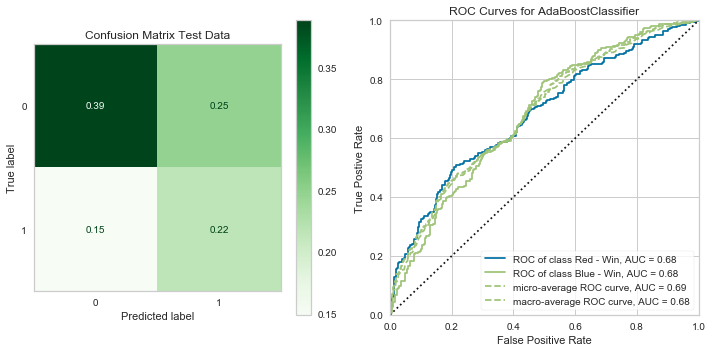

---- Timer stopped at: 04/27/2020 - 10:08 PM ----
---- Time elasped: 0:03:04.412768 ----


In [127]:
mods_skim_fin = [log_skim1, log_skim2, ada_skim]
mod_labs_skim_fin = ['log_skim1', 'log_skim2', 'ada_skim']
t_skim_fin = dlf.Timer()

times_skim_fin = dlf.time_models(X_trn_sca_resmp_bin_skim, X_test_sca_bin_skim, y_trn_resmp_bin_skim, y_test_bin_skim, mods_skim_fin, mod_labs_skim_fin, t_skim_fin, cls_lab=labs_bin)

> It has actually lowered the accuracy! I will stick with my 2nd model moving forward.

## Final Results

> Throughout the duration of this project, I have created and tuned three models looking at the data three different ways. My results and correspsonding model parameters are as follows:

##### Multiclass Classifier

In [ ]:
#multi_y_trn, multi_y_te = fit_n_pred(xgb_fin, X_trn_sca_resmp, X_test_sca, y_trn_resmp)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
              max_depth=2, min_child_weight=1, missing=None, n_estimators=50,
              n_jobs=1, nthread=None, num_class=3, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

Classification Report:
              precision    recall  f1-score   support

           0       0.02      0.09      0.04        23
           1       0.72      0.71      0.71       845
           2       0.46      0.41      0.44       418

    accuracy                           0.60      1286
   macro avg       0.40      0.40      0.40      1286
weighted avg       0.63      0.60      0.61      1286



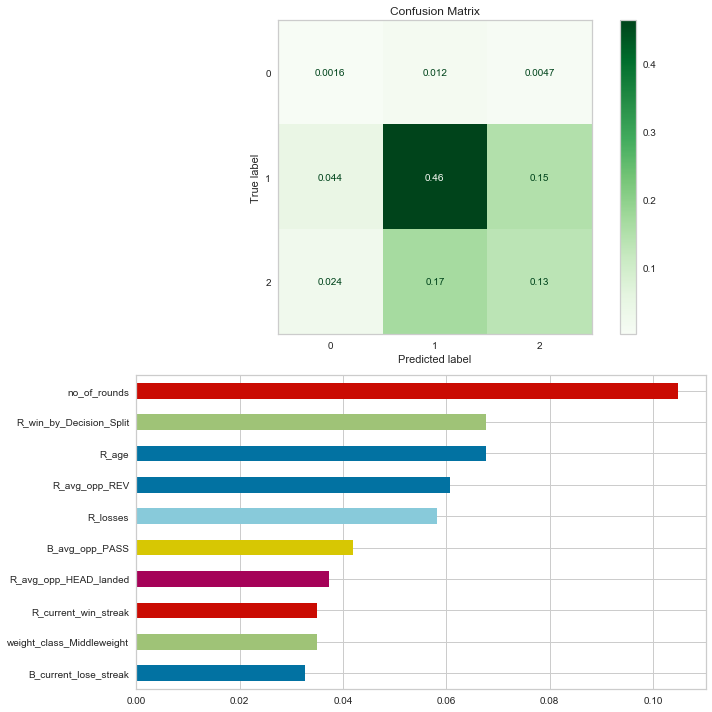

In [140]:
dlf.summarize_model(xgb_fin, X_trn_sca_resmp, X_test_sca, y_trn_resmp, y_test, tree=True)

##### Binary Classifier (No Draws)

In [ ]:
#y_hat_trn_bin, y_hat_te_bin = fit_n_pred(log_clf_bin_fin, X_trn_sca_resmp_bin, X_test_sca_bin, y_trn_resmp_bin)

LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.69      0.73       850
           1       0.49      0.61      0.54       416

    accuracy                           0.66      1266
   macro avg       0.64      0.65      0.64      1266
weighted avg       0.69      0.66      0.67      1266



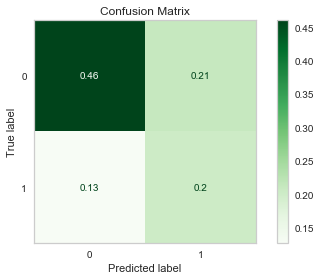

In [141]:
dlf.summarize_model(log_clf_bin_fin, X_trn_sca_resmp_bin, X_test_sca_bin, y_trn_resmp_bin, y_test_bin)

In [142]:
bin_full_test_probs = log_clf_bin_fin.predict_proba(X_test_sca_bin)
bin_full_test_probs

array([[0.35900333, 0.64099667],
       [0.45309112, 0.54690888],
       [0.78566549, 0.21433451],
       ...,
       [0.5289652 , 0.4710348 ],
       [0.57125872, 0.42874128],
       [0.86817068, 0.13182932]])

##### Binary Classifier (No rookies)

In [ ]:
#y_hat_trn_skim, y_hat_te_skim = fit_n_pred(log_skim1, X_train_sca_bin_skim, X_test_sca_bin_skim, y_train_bin_skim)

LogisticRegression(C=10000000000.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.61      0.66       457
           1       0.47      0.61      0.53       262

    accuracy                           0.61       719
   macro avg       0.60      0.61      0.60       719
weighted avg       0.64      0.61      0.62       719



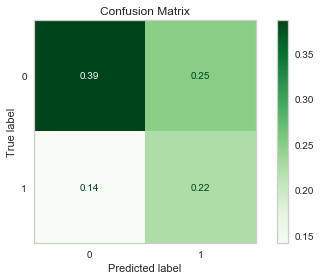

In [143]:
dlf.summarize_model(log_skim1, X_trn_sca_resmp_bin_skim, X_test_sca_bin_skim, y_trn_resmp_bin_skim, y_test_bin_skim)

In [144]:
bin_skim_test_probs = log_skim1.predict_proba(X_test_sca_bin_skim)
bin_skim_test_probs

array([[0.233598  , 0.766402  ],
       [0.37351678, 0.62648322],
       [0.64074403, 0.35925597],
       ...,
       [0.89681032, 0.10318968],
       [0.63998927, 0.36001073],
       [0.70465062, 0.29534938]])

### Recommendation & Future Work

> Given these results, I would recommend using one of the two binary classification models to make their predicitions. Out of the two, I recommend the model trained on data containing 1st time fighters `log_clf_bin_fin`, as it has already seen data as such and over time with further development, be able to make a better prediction if fed that data.

> The reasoning behind choosing this model is for its purpose: **to allow interested parties to have a probability value** associated with any given fighter to win the match. Although 66% overall accuracy is not high, this model recieved this score by correctly guessing over *both* classes (46%, 20%); whereas other modeling attempts correctly guessed *one* class ~65% right while missing almost all of guesses at the other. 

> As for the multi-class model, being unable to predict a draw at all is something that may require *more* data preprocessing or a different modeling strategy. Looking at the confusion matrix for it, the model clearly only predicted actual wins by either corner, which is why I decided to drop that class entirely.

> If these models were to be used in any capacity, I can tailor the input features to whatever is necessary. As-is, I would expect it to be run using the same information scraped from [ufcstats.com](http://www.ufcstats.com/statistics/events/completed), but could always be altered to accept different subsets of features. 

> Additionally, combat sports by nature are very volatile when it comes to determining a winner. There are numerous ways to "get lucky" and steal a win, or to simply be in bad shape. There are intangibles such as "having heart" or a "strong chin" that would be difficult to quantify. In addition, important information such as fighting styles or what training camp they fight for could prove to be valuable to my model. Otherwise, given more time I would like to play more with what attributes I can add (or remove) in order to inch my accuracy higher. 